## Preparación del entorno
## Definición del contexto biológico de estudio, método de normalización, cáncer de interés y ruta del archivo a los datos crudos

### Mensajes de salida personalizados

In [1]:
from pathlib import Path
from IPython.display import display, HTML, Markdown

# Configuración de estilos
STYLES = {
    "result": {"bg": "#e9f5ff", "text": "#004085", "icon": "📊"},
    "success": {"bg": "#eaf4ea", "text": "#2e6637", "icon": "🧬"},
    "error": {"bg": "#f8d7da", "text": "#721c24", "icon": "🧫"},
    "alert": {"bg": "#fff3cd", "text": "#856404", "icon": "💊"},
    "export": {"bg": "#e0f2f1", "text": "#00695c", "icon": "💾"},
    "resume": {"bg": "#fff3cd", "text": "#856404", "icon": "🔔", "title": "Resumen de ejecución"}
}


def resume_message(items: dict, title: str = "Resumen de ejecución") -> None:
    """Muestra un resumen organizado de parámetros/configuraciones"""
    formatted_lines = [f"{k}: {v}" for k, v in items.items()]
    summary = "\n".join(formatted_lines)
    
    html_content = f"""
    <div style="background-color:{STYLES['resume']['bg']}; 
                color:{STYLES['resume']['text']};
                padding: 12px; 
                border-radius: 8px;
                border-left: 4px solid {STYLES['resume']['text']};
                margin: 10px 0;
                box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
        <div style="font-size: 1.1em; margin-bottom: 6px;">
            {STYLES['resume']['icon']} <strong>{title}</strong>
        </div>
        <div style="font-size: 0.95em; margin-left: 24px;">
            {"".join([f'<div><strong>{k.split(":")[0]}:</strong> {v}</div>' for k, v in [line.split(":", 1) for line in formatted_lines]])}
        </div>
    </div>
    """
    display(HTML(html_content))

def display_message(text: str, style_type: str) -> None:
    """Muestra mensajes estilizados en notebooks Jupyter"""
    if style_type not in STYLES:
        raise ValueError(f"Estilo inválido. Opciones: {list(STYLES.keys())}")
    
    style = STYLES[style_type]
    parts = text.split(':', 1) if ':' in text else [text, '']
    
    html_content = f"""
    <div style="background-color:{style['bg']}; 
                color:{style['text']};
                padding: 12px; 
                border-radius: 8px;
                border-left: 4px solid {style['text']};
                margin: 10px 0;
                box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
        <div style="font-size: 1.1em; margin-bottom: 6px;">
            {style['icon']} <strong>{parts[0].strip()}</strong>
        </div>
        <div style="font-size: 0.95em; margin-left: 24px;">
            {parts[1].strip()}
        </div>
    </div>
    """
    display(HTML(html_content))

# Funciones especializadas
def result_message(text: str) -> None:
    """Mensaje para resultados de análisis"""
    display_message(text, "result")

def success_message(text: str) -> None:
    """Mensaje de operación exitosa"""
    display_message(text, "success")

def error_message(text: str) -> None:
    """Mensaje de error crítico"""
    display_message(text, "error")

def alert_message(text: str) -> None:
    """Mensaje de advertencia o alerta"""
    display_message(text, "alert")

def export_message(text: str) -> None:
    """Mensaje para operaciones de exportación"""
    display_message(text, "export")


### Carga de la configuración

Este módulo es el núcleo de la configuración del pipeline y se encarga de cargar y validar los parámetros del archivo config.yaml (como rutas de datos, métodos de análisis y tipo de cáncer), asegurándose de que no falte información crítica. Además, organiza automáticamente las carpetas de resultados en una estructura clara (para evitar errores manuales. Si trabajan en Google Colab, también puede montar Google Drive con solo activar una opción en la configuración. En resumen: ellas solo modifican el config.yaml y el código se encarga de validar, crear rutas y preparar todo para que el análisis fluya sin problemas. Si algo falla, mostrará mensajes de error específicos (ej.: "Falta el método de normalización en el YAML") para que corrijan fácilmente.

In [2]:

def configurar_rutas(config):
    """
    Configura las rutas del proyecto y crea la estructura de directorios para resultados.
    
    Args:
        config (dict): Configuración cargada del archivo YAML
    
    Returns:
        dict: Diccionario con:
            - ruta_archivo: Path al archivo de datos crudos
            - ruta_resultados: Path a la carpeta de resultados creada
    
    Raises:
        FileNotFoundError: Si no existe el archivo de datos crudos
        Exception: Para otros errores relacionados con rutas
    """
    try:
        # Verifica que exista el archivo de datos crudos
        ruta_archivo = Path(config['rutas']['datos_crudos'])
        if not ruta_archivo.exists():
            raise FileNotFoundError(f"Archivo de datos no encontrado: {ruta_archivo}")
        
        # Crea estructura de directorios para resultados
        nombre_archivo = ruta_archivo.stem  # Nombre del archivo sin extensión
        ruta_resultados = Path(
            f"{config['rutas']['resultados_base']}/"
            f"{nombre_archivo}/"
            f"{config['analisis']['contexto_biologico']}/"
            f"{config['analisis']['metodo_normalizacion']}/"
            f"{config['analisis']['tipo_cancer']}/"
        )
        # Crea los directorios (incluyendo padres si no existen)
        ruta_resultados.mkdir(parents=True, exist_ok=True)
        
        return {
            'ruta_archivo': ruta_archivo,
            'ruta_resultados': ruta_resultados
        }
        
    except Exception as e:
        error_message(f"Error configurando rutas: {str(e)}")
        raise

### Guardado de resultados

In [3]:
# src/io.py
import pandas as pd
from pathlib import Path
import os

# Variable global para almacenar la ruta de exportación
_default_export_folder = None

def set_export_folder(path):
    global _default_export_folder
    _default_export_folder = Path(path)

def export_dfs_to_excel(dataframes, file_names, note="", export_folder=None):
    """Exporta múltiples DataFrames a Excel"""
    try:
        # Usar la variable global si no se especifica explícitamente
        export_folder = export_folder or _default_export_folder
        
        if not export_folder:
            raise ValueError("Debe especificar carpeta de exportación")
            
        if len(dataframes) != len(file_names):
            raise ValueError("dataframes y file_names deben tener misma longitud")

        export_path = Path(export_folder)
        export_path.mkdir(parents=True, exist_ok=True)
        
        file_name = note.split(':', 1)[0] if ':' in note else "resultados"
        file_path = export_path / f"{file_name}.xlsx"

        with pd.ExcelWriter(file_path, engine='openpyxl') as writer:
            for df, sheet_name in zip(dataframes, file_names):
                if not df.empty:
                    df.to_excel(writer, sheet_name=sheet_name[:31], index=False)
                    
        export_message(f"Archivo exportado: {file_name}.xlsx {note}")
        return file_path
        
    except Exception as e:
        alert_message(f"Error en exportación: {str(e)}")
        raise

def guardar_grafico(fig, nombre_archivo, carpeta=None):
    """Guarda gráficos en formato PNG"""
    try:
        # Usar la variable global si no se especifica explícitamente
        carpeta = carpeta or _default_export_folder
        
        if not carpeta:
            raise ValueError("Debe especificar carpeta de guardado")
            
        ruta_completa = Path(carpeta) / nombre_archivo
        fig.write_image(str(ruta_completa), format='png', scale=2)
        success_message(f"Gráfico guardado: {nombre_archivo}")
        return ruta_completa
        
    except Exception as e:
        alert_message(f"Error guardando gráfico: {str(e)}")
        raise

In [4]:


# notebooks/analisis.ipynb
import sys
from pathlib import Path
import pandas as pd

sys.path.append("../src")

# -----------------------------------------------
# Cargar configuración desde Excel
# -----------------------------------------------
ruta_excel = Path("../raw_data/CG-TEM-intestinal_prueba.xlsx")
df_excel = pd.read_excel(ruta_excel, sheet_name=0, header=None)

# Extraer parámetros desde ubicaciones específicas
ruta_archivo = ruta_excel  # Ya es la fuente de datos
contexto_biologico = df_excel.iloc[2, 1]  # Fila 4, Columna B
metodo_elegido = df_excel.iloc[1, 1]      # Fila 3, Columna B
tipo_cancer = df_excel.iloc[0, 1]         # Fila 2, Columna B

# Extraer nombre de controles desde la celda B4
nombre_controles = df_excel.iloc[3, 1]

# Extraer nombre de muestra desde la celda B5
nombre_muestras = df_excel.iloc[4, 1]
# -----------------------------------------------
# Configurar rutas
# -----------------------------------------------
nombre_archivo = ruta_archivo.stem
ruta_resultados = Path(
    f"../resultados/"
    f"{nombre_archivo}/"
    f"{contexto_biologico}/"
    f"{metodo_elegido}/"
    f"{tipo_cancer}/"
)
ruta_resultados.mkdir(parents=True, exist_ok=True)

#from utils.helpers import set_export_folder, success_message, resume_message

set_export_folder(ruta_resultados)

# ==================================================
# VISUALIZACIÓN DE CONFIGURACIÓN
# ==================================================

success_message("Configuración cargada desde Excel")

# Mostrar parámetros
resume_message({
    "Contexto biológico": contexto_biologico,
    "Método de normalización": metodo_elegido,
    "Tipo de cáncer": tipo_cancer,
    "Controles": nombre_controles,
    "Muestras": nombre_muestras
})

success_message("Configuración de las variables de análisis cargadas correctamente")

# Mostrar rutas
resume_message({
    "Archivo de datos": ruta_archivo,
    "Directorio de resultados": ruta_resultados
})
success_message("Configuración de rutas cargadas correctamente")

# Verificación final
success_message("✓ Configuración válida")

/opt/anaconda3/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


## Importación de librerías esenciales para el análisis de expresión génica

Este bloque de código importa una serie de librerías fundamentales para realizar análisis avanzados en el contexto de la expresión génica.


### Configuración del entorno

In [5]:
from pathlib import Path
import importlib
import subprocess
import sys
import os
import pandas as pd
import numpy as np
from IPython.display import display, Markdown, HTML
import requests
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import networkx as nx
import warnings
import contextlib
import io


# Configuración inicial del entorno
def configure_environment():
    # Configuración de pandas
    pd.set_option('display.max_colwidth', 100)
    
    # Manejo de advertencias de Python
    warnings.filterwarnings('ignore')
    
    # Lista de paquetes a verificar e instalar si es necesario
    packages_to_check = [
        'markdown',
        'gseapy',
        'biopython',
        'squarify',
        'openpyxl',
        'goatools',
        'kaleido',
        'py2cytoscape'
    ]
    
    installed_packages = []
    
    # Redirección de stdout y stderr para ocultar mensajes molestos
    with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
        for package in packages_to_check:
            try:
                importlib.import_module(package)
                installed_packages.append(package)
            except ImportError:
                alert_message(f"Instalando {package}...")
                try:
                    subprocess.check_call(
                        [sys.executable, "-m", "pip", "install", package],
                        stdout=subprocess.DEVNULL,
                        stderr=subprocess.DEVNULL
                    )
                    installed_packages.append(package)
                except Exception as e:
                    error_message(f"Error instalando {package}: {str(e)}")

    success_message(f"Paquetes instalados: {', '.join(installed_packages)}")

    # Importaciones posteriores a la instalación
    import gseapy as gp
    import squarify
    import kaleido

    success_message("Entorno configurado correctamente")

configure_environment()


## Limpieza de datos


### Definición de los nombres de los controles y las muestras


### Carga del archivo de Excel y extracción de información

En esta sección se realiza la carga de un archivo de Excel que contiene los datos de Ct de diversas pruebas. El proceso se divide en dos pasos fundamentales:

1. **Carga del archivo de Excel**  
   Se define una función llamada `cargar_datos_excel` que recibe como argumento la ruta del archivo. La función intenta cargar el archivo utilizando `pandas.read_excel` y maneja posibles errores.
   
   Si el archivo se carga correctamente, se muestra un mensaje de éxito; de lo contrario, se interrumpe la ejecución del programa.

2. **Extracción de información relevante**  
   La función `extraer_informacion` se encarga de extraer tres elementos importantes del DataFrame cargado: Nombres de las pruebas, Pozos y Genes objetivo.

Finalmente, se muestran los resultados de la extracción en pantalla, confirmando que el proceso se ha llevado a cabo correctamente.

In [6]:
import pandas as pd
import numpy as np
from IPython.display import display, Markdown

# ============================================================
# FUNCIÓN DE CARGA DE DATOS
# ============================================================
def cargar_datos_excel(ruta):
    display(Markdown("### Resultados de la extracción"))
    try:
        df = pd.read_excel(ruta, engine='openpyxl', header=None)
        success_message("Archivo cargado correctamente")
        return df
    except FileNotFoundError:
        error_message(f"Archivo '{ruta}' no encontrado")
    except Exception as e:
        error_message(f"Error al cargar: {e}")
    return None

# ============================================================
# FUNCIÓN PARA EXTRAER NOMBRES DE PRUEBAS, POZOS Y GENES
# ============================================================
def extraer_informacion_cg(df: pd.DataFrame) -> tuple:
    rows, cols = df.shape
    if rows < 9 or cols < 3:
        alert_message("El archivo no tiene el formato esperado.")
        return [], [], []
    test_names = df.iloc[5, 2:].dropna().astype(str).tolist()
    pozos = df.iloc[9:, 0].dropna().astype(str).tolist()
    genes = df.iloc[9:, 1].dropna().astype(str).tolist()
    return test_names, pozos, genes

# ============================================================
# FUNCIÓN PARA PROCESAR VALORES CT Y CLASIFICARLOS
# ============================================================
def procesar_ct(df: pd.DataFrame, genes: list, nombre_controles: str, nombre_muestras: str) -> tuple:
    if len(df) <= 8:
        alert_message("El DataFrame no tiene suficientes filas.")
        return pd.DataFrame(), pd.DataFrame()

    fila_ct = df.iloc[7]
    if not any(str(val).strip().upper() == "CT" for val in fila_ct.values):
        alert_message("No se encontró ninguna columna con 'CT' en la fila 7.")
        return pd.DataFrame(), pd.DataFrame()

    # Normalizar prefijos
    nombre_controles = nombre_controles.strip().upper()
    nombre_muestras = nombre_muestras.strip().upper()

    controles_list = []
    muestras_list = []

    for idx in np.where(fila_ct == "CT")[0]:
        raw_test_name = str(df.iloc[5, idx])
        nombre_test = raw_test_name.strip().upper()
        print(f"[DEBUG] idx={idx}, nombre_test='{nombre_test}'")

        ct_values = df.iloc[8:, idx].tolist()
        if len(ct_values) < len(genes):
            ct_values.extend([np.nan] * (len(genes) - len(ct_values)))
        elif len(ct_values) > len(genes):
            ct_values = ct_values[:len(genes)]

        df_temp = pd.DataFrame({
            'test': [nombre_test] * len(genes),
            'target': genes,
            'ct': ct_values
        })

        if nombre_test.startswith(nombre_controles):
            controles_list.append(df_temp)
            result_message(f"Control detectado: {nombre_test}")
        elif nombre_test.startswith(nombre_muestras):
            muestras_list.append(df_temp)
            result_message(f"Muestra detectada: {nombre_test}")
        else:
            alert_message(f"'{nombre_test}' no coincide con control ni muestra. Se omite.")

    controles_df = pd.concat(controles_list, ignore_index=True) if controles_list else pd.DataFrame()
    muestras_df = pd.concat(muestras_list, ignore_index=True) if muestras_list else pd.DataFrame()
    return controles_df, muestras_df

# ============================================================
# FLUJO PRINCIPAL DE PROCESAMIENTO
# ============================================================
def flujo_procesamiento(ruta_archivo: str, nombre_controles: str, nombre_muestras: str) -> dict:
    df = cargar_datos_excel(ruta_archivo)
    if df is None:
        raise SystemExit(f"❌ Error crítico: No se pudo cargar el archivo '{ruta_archivo}'")

    test_names, pozos, genes = extraer_informacion_cg(df)

    for titulo, datos, filtro in [
        ("### Nombres de las pruebas realizadas", test_names, lambda x: x[1:]),
        ("### Genes objetivo analizados", genes, lambda x: [g for g in x if pd.notna(g) and g.strip()])
    ]:
        display(Markdown(titulo))
        datos_filtrados = filtro(datos)
        result_message(f"Total {len(datos_filtrados)}: \n{', '.join(datos_filtrados)}")

    controles_df, muestras_df = procesar_ct(df, genes, nombre_controles, nombre_muestras)

    display(Markdown("### Resumen de clasificación"))
    for tipo, df_tipo in [('Controles', controles_df), ('Muestras', muestras_df)]:
        if not df_tipo.empty:
            unique_tests = df_tipo['test'].unique()
            result_message(f"{tipo}: {len(unique_tests)} pruebas → {', '.join(unique_tests)}")
        else:
            alert_message(f"No se detectaron {tipo.lower()} en el archivo.")

    success_message("Proceso de CT completado exitosamente")
    return {
        "test_names": test_names,
        "pozos": pozos,
        "genes": genes,
        "controles_df": controles_df,
        "muestras_df": muestras_df
    }

# ============================================================
# EJECUCIÓN DEL FLUJO
# ============================================================
# ruta_archivo = "../raw_data/CG-TEM-intestinal_prueba.xlsx"
# nombre_controles = "4GB"
# nombre_muestras = "3CG"
resultados = flujo_procesamiento(ruta_archivo, nombre_controles, nombre_muestras)
controles_df = resultados['controles_df']
muestras_df = resultados['muestras_df']

### Resultados de la extracción

### Nombres de las pruebas realizadas

### Genes objetivo analizados

[DEBUG] idx=2, nombre_test='4GB001'


[DEBUG] idx=3, nombre_test='4GB031'


[DEBUG] idx=4, nombre_test='3CG008'


[DEBUG] idx=5, nombre_test='3CG128'


[DEBUG] idx=6, nombre_test='3CG046'


### Resumen de clasificación

### Procesamiento de valores Ct indeterminados

Esta sección del código se encarga de procesar los valores de **Ct** en los dataframes de controles y muestras, reemplazando valores indeterminados y asegurando que la columna de Ct esté en formato numérico adecuado, si hay datos faltantes estos se eliminan para no agregar ruido a los cálculos

In [7]:
import pandas as pd
from IPython.display import display, Markdown

def procesar_ct_column(df1, df2, columna_ct='ct'):
    """
    Imputa 'Undetermined' y valores faltantes con el valor máximo encontrado en ambas columnas Ct.

    Args:
        df1, df2: DataFrames con columna 'ct'
        columna_ct: nombre de la columna Ct

    Returns:
        df1, df2: con imputación lista
    """
    def procesar(df, columna):
        # Reemplazar 'Undetermined' por NaN
        df[columna] = df[columna].replace('Undetermined', pd.NA)
        df[columna] = pd.to_numeric(df[columna], errors='coerce')
        return df

    # Paso 1: Reemplazo y conversión
    df1 = procesar(df1, columna_ct)
    df2 = procesar(df2, columna_ct)

    # Paso 2: Encontrar el valor máximo observado entre ambos DF (sin contar NaN)
    valor_maximo = pd.concat([df1[columna_ct], df2[columna_ct]]).max()

    # Paso 3: Imputar NaNs con ese valor
    df1[columna_ct] = df1[columna_ct].fillna(valor_maximo)
    df2[columna_ct] = df2[columna_ct].fillna(valor_maximo)

    # Paso 4: Mostrar resumen
    display(Markdown("### Procesamiento completado"))
    display(Markdown(f"- Valor máximo usado para imputación: **{valor_maximo}**"))
    return df1, df2

# Procesamos los DataFrames de controles y muestras
try:
    controles_df, muestras_df = procesar_ct_column(controles_df, muestras_df)
    success_message("Procesamiento de valores de Ct finalizado")
except Exception as e:
    error_message(f"Ocurrió un error en el procesamiento de valores de Ct: {e}")



### Procesamiento completado

- Valor máximo usado para imputación: **44.93**

### Filtrado de controles de máquina y concatenación de datos

En esta sección del código se realiza el filtrado de los controles de máquina de los dataframes y la concatenación de los resultados para obtener un dataframe combinado que clasifica las filas según su tipo (control o muestra).


In [8]:
def filtrar_controles_maquina(df, columna_target='target', controles_maquina=None):
    """
    Filtra las filas de un DataFrame eliminando aquellas que contienen controles de máquina,
    definidos como aquellos cuyo valor en la columna 'columna_target' comienza con alguno
    de los prefijos especificados en controles_maquina.

    Args:
        df (pd.DataFrame): DataFrame que contiene los datos a filtrar.
        columna_target (str): Nombre de la columna que contiene los targets (por defecto, 'target').
        controles_maquina (list, opcional): Lista de prefijos de controles de máquina a eliminar.
            Si no se proporciona, se utilizará la lista por defecto: ['PPC', 'RTC'].

    Returns:
        pd.DataFrame: DataFrame filtrado sin los controles de máquina.
    """
    # Lista por defecto de controles de máquina si no se proporciona
    if controles_maquina is None:
        controles_maquina = ['PPC', 'RTC']

    alert_message(f"Controles de máquina a eliminar: {', '.join(controles_maquina)}")

    # Filtrado del DataFrame eliminando los controles de máquina que comienzan con alguno de los prefijos
    df_filtrado = df[~df[columna_target].str.startswith(tuple(controles_maquina))]
    success_message("Filas eliminadas con controles de máquina")

    return df_filtrado

# Filtrar los controles de máquina de los DataFrames
display(Markdown("### Filtrado de controles de máquina para los datos en controles"))
controles_df = filtrar_controles_maquina(controles_df)
display(Markdown("### Filtrado de controles de máquina para los datos en muestras"))
muestras_df = filtrar_controles_maquina(muestras_df)

# Añadir columna para identificar el tipo de cada fila
controles_df = controles_df.assign(tipo='Control')
muestras_df = muestras_df.assign(tipo='Muestra')

export_dfs_to_excel(
    [controles_df, muestras_df],
    ["datos_control_limpio", "datos_muestras_limpio"],
    "Datos limpios de controles y muestras: Archivo que contiene los datos de controles y muestras limpios, sin valores nulos ni controles de máquina.", ruta_resultados
)

### Filtrado de controles de máquina para los datos en controles

### Filtrado de controles de máquina para los datos en muestras

PosixPath('../resultados/CG-TEM-intestinal_prueba/Cáncer y TEM/gen de referencia/Gastric Cancer/Datos limpios de controles y muestras.xlsx')

## Procesamiento de datos

### Análisis de expresión génica mediante CT y Fold Change utilizando las metodologías promedio CT de un gen de referencia y promedio global

#### Método con gen de referencia

1. Promedio de Ct para cada gen:

$$\text{Promedio } Ct_{\text{gen de referencia}} \hspace{5pt}= \frac{Ct_1 + Ct_2 + Ct_3 + ... +Ct_n}{n}$$

2. ΔCt para cada condición:

$$\Delta Ct = \text{Promedio } Ct_{\text{gen de interés}} \hspace{5pt}- \text{Promedio } Ct_{\text{gen de referencia}}$$

3. ΔΔCt:

$$\Delta\Delta Ct = \Delta Ct_{\text{muestra}} - \Delta Ct_{\text{control}}
$$

4. Fold Change:

$$\text{Fold Change} = 2^{-\Delta\Delta Ct}$$

#### Métdodo con promedio global

1. Promedio de Ct para cada gen:

$$
\text{Promedio } Ct_{\text{gen}} = \frac{Ct_1 + Ct_2 + Ct_3 + ... + Ct_n}{n}
$$

2. Promedio global de Ct para cada condición

$$
\text{Promedio global } Ct_{\text{condición}} \hspace{5pt}= \frac{\sum \text{Promedio } Ct_{\text{gen}}}{N}
$$

3. ΔCt para cada gen:

$$
\Delta Ct_{\text{gen}} = \text{Promedio } Ct_{\text{gen}} - \text{Promedio global } Ct_{\text{condición}}
$$

4. ΔΔCt para cada gen:

$$
\Delta\Delta Ct_{\text{gen}} = \Delta Ct_{\text{gen, tratamiento}} \hspace{5pt}- \Delta Ct_{\text{gen, control}}
$$

5. Fold Change:

$$
\text{Fold Change} = 2^{-\Delta\Delta Ct_{\text{gen}}}
$$

In [9]:
from typing import Tuple
import pandas as pd

def calcular_fold_change(
    controles: pd.DataFrame,
    muestras: pd.DataFrame
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Calcula el fold change usando los dataframes de controles y muestras.


    1. Agrupamos los datos por 'target' y calculamos la media y la desviación estándar (CT).
    2. Calculamos los delta CT comparando cada gen con el promedio general.
    3. Seleccionamos el gen más estable: el que tiene la menor variabilidad (promedio de desviaciones).
    4. Utilizamos este gen de referencia para normalizar y obtener el fold change.
    """

    # Función auxiliar para procesar cada grupo (controles o muestras) 🧪📊
    def procesar_grupo(df: pd.DataFrame, grupo: str) -> pd.DataFrame:
        # Agrupamos por gen y calculamos estadísticas básicas
        stats = df.groupby('target', as_index=False).agg(
            ct_promedio=('ct', 'mean'),
            ct_std=('ct', 'std')
        ).rename(columns={
            'ct_promedio': f'ct_promedio_{grupo}',
            'ct_std': f'ct_std_{grupo}'
        })
        return stats

    # Procesamos los dataframes de controles y muestras
    stats_controles = procesar_grupo(controles, 'controles')
    stats_muestras = procesar_grupo(muestras, 'muestras')

    # Calculamos el promedio general de CT para cada grupo 📈
    stats_controles['promedio_general_controles'] = stats_controles['ct_promedio_controles'].mean()
    stats_muestras['promedio_general_muestras'] = stats_muestras['ct_promedio_muestras'].mean()

    # Calculamos el delta CT con respecto al promedio general 🧮
    stats_controles['delta_ct_promedio_controles'] = stats_controles['ct_promedio_controles'] - stats_controles['promedio_general_controles']
    stats_muestras['delta_ct_promedio_muestras'] = stats_muestras['ct_promedio_muestras'] - stats_muestras['promedio_general_muestras']

    # Merge inicial de controles y muestras en un solo dataframe 🔀
    df_consolidado = pd.merge(
        stats_controles,
        stats_muestras,
        on='target',
        how='outer',  # Se mantienen todos los targets 🤝
        suffixes=('_controles', '_muestras')
    )

    # Selección del gen más estable 🔬📉:
    # Se define la estabilidad como el promedio de las desviaciones estándar de controles y muestras
    df_consolidado['stability'] = (df_consolidado['ct_std_controles'] + df_consolidado['ct_std_muestras']) / 2
    gen_mas_estable = df_consolidado.loc[df_consolidado['stability'].idxmin(), 'target']


    # Muestra una alerta con el gen de referencia seleccionado 🚨✨
    # alert_message debe estar definida en otro lugar con la siguiente estructura:
    # def alert_message(text):
    #     """
    #     Muestra un mensaje de alerta.
    #
    #     Args:
    #         text (str): Texto del mensaje.
    #     """
    alert_message(f"Gen de referencia seleccionado: {gen_mas_estable} ")

    # Cálculo del delta CT respecto al gen de referencia (más estable) 🎯
    ref_controles = stats_controles.query("target == @gen_mas_estable")['ct_promedio_controles'].values[0]
    ref_muestras = stats_muestras.query("target == @gen_mas_estable")['ct_promedio_muestras'].values[0]

    stats_controles['delta_ct_gen_ref_controles'] = stats_controles['ct_promedio_controles'] - ref_controles
    stats_muestras['delta_ct_gen_ref_muestras'] = stats_muestras['ct_promedio_muestras'] - ref_muestras

    # Merge final para incorporar los cálculos de fold change 🔗
    df_consolidado = pd.merge(
        stats_controles,
        stats_muestras,
        on='target',
        how='outer',
        suffixes=('_controles', '_muestras')
    )

    # Cálculo del fold change utilizando el método del promedio 📊🏎️
    df_consolidado['delta_delta_ct_promedio'] = (
        df_consolidado['delta_ct_promedio_muestras'] - df_consolidado['delta_ct_promedio_controles']
    )
    df_consolidado['fold_change_promedio'] = 2 ** (-df_consolidado['delta_delta_ct_promedio'])

    # Cálculo del fold change utilizando el método del gen de referencia 🎯🔢
    df_consolidado['delta_delta_ct_gen_ref'] = (
        df_consolidado['delta_ct_gen_ref_muestras'] - df_consolidado['delta_ct_gen_ref_controles']
    )
    df_consolidado['fold_change_gen_ref'] = 2 ** (-df_consolidado['delta_delta_ct_gen_ref'])

    # Preparación de dataframes especializados para exportar 📑
    cols_promedio = ['target'] + [c for c in df_consolidado.columns if 'promedio' in c]
    cols_gen_ref = ['target'] + [c for c in df_consolidado.columns if 'gen_ref' in c]

    df_promedios = df_consolidado[cols_promedio].copy()
    df_promedios.rename(columns={'fold_change_promedio': 'fold_change'}, inplace=True)
    df_gen_ref = df_consolidado[cols_gen_ref].copy()
    df_gen_ref.rename(columns={'fold_change_gen_ref': 'fold_change'}, inplace=True)

    success_message("Cálculo de fold change finalizado 🚀")

    return df_consolidado, df_promedios, df_gen_ref, gen_mas_estable


# Ejemplo de uso:
# Se asume que controles_df y muestras_df ya están definidos
df_consolidado, df_promedios, df_gen_ref, gen_referencia= calcular_fold_change(controles_df, muestras_df)

# Exportar todos los dataframes a un archivo Excel 📤📊
export_dfs_to_excel(
    [df_consolidado, df_promedios, df_gen_ref],
    ['consolidado_promedios_y_gen_ref', 'fc_metodo_promedios', 'fc_metodo_gen_ref'],
    "Calculo de fold change: Archivo que contiene los cálculos realizados y los valores de fold change por método."
)




PosixPath('../resultados/CG-TEM-intestinal_prueba/Cáncer y TEM/gen de referencia/Gastric Cancer/Calculo de fold change.xlsx')

In [10]:
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.cluster.hierarchy import linkage


df_total = pd.concat([controles_df, muestras_df])

# ------------------------------
# 3. Normalización de datos según el método elegido
# ------------------------------
if metodo_elegido == "gen de referencia":
    # Se extrae el Ct del gen de referencia para cada test
    ref_ct = df_total[df_total['target'] == gen_referencia][['test', 'ct']].rename(
        columns={'ct': f'{gen_referencia}_ct'}
    )
    df_norm = df_total.merge(ref_ct, on='test')
    df_norm['delta_ct'] = df_norm['ct'] - df_norm[f'{gen_referencia}_ct']
    df_norm['log2_rel_expr'] = -df_norm['delta_ct']  # log2(2^(-ΔCt)) = -ΔCt

elif metodo_elegido == "promedios":
    # Se calcula el promedio de Ct para cada test y se normaliza respecto a ese promedio
    df_norm = df_total.copy()
    df_norm['ct_promedio_test'] = df_norm.groupby('test')['ct'].transform('mean')
    df_norm['delta_ct_promedio'] = df_norm['ct'] - df_norm['ct_promedio_test']
    df_norm['log2_rel_expr'] = -df_norm['delta_ct_promedio']

else:
    raise ValueError("El método de normalización debe ser 'gen de referencia' o 'promedios'.")

# Crear la matriz para el heatmap (tabla pivote)
# Si se normaliza por gen de referencia, se elimina dicho gen de la matriz
if metodo_elegido == "gen de referencia":
    heatmap_data = df_norm.pivot_table(
        index='target',
        columns='test',
        values='log2_rel_expr',
        aggfunc='mean'
    ).drop(gen_referencia, errors='ignore')
else:
    heatmap_data = df_norm.pivot_table(
        index='target',
        columns='test',
        values='log2_rel_expr',
        aggfunc='mean'
    )

# ------------------------------
# 4. (Filtrado por firmas - OMITIDO)
# ------------------------------
# heatmap_data_sobre = heatmap_data[heatmap_data.index.isin(lista_sobre)]
# heatmap_data_sub   = heatmap_data[heatmap_data.index.isin(lista_sub)]

# ------------------------------
# 5. Crear el clustergrama (heatmap con dendrogramas)
# ------------------------------
def create_clustered_heatmap(heatmap_data, title):
    # Clustering y dendrogramas para columnas (tests)
    dendro_col = ff.create_dendrogram(
        heatmap_data.T,
        orientation='bottom',
        labels=heatmap_data.columns.tolist(),
        linkagefun=lambda x: linkage(x, method='average', metric='euclidean')
    )
    col_order = dendro_col['layout']['xaxis']['ticktext']

    # Clustering y dendrogramas para filas (genes)
    dendro_row = ff.create_dendrogram(
        heatmap_data,
        orientation='right',
        labels=heatmap_data.index.tolist(),
        linkagefun=lambda x: linkage(x, method='average', metric='euclidean')
    )
    row_order = dendro_row['layout']['yaxis']['ticktext']

    # Reordenar la matriz según el clustering obtenido
    clustered_data = heatmap_data.loc[row_order, col_order]

    # Definir la escala de colores personalizada:
    # - Valores bajos (subexpresados): azul
    # - 0 (expresión similar al método de normalización): amarillo pastel
    # - Valores altos (sobreexpresados): rojo
    custom_colorscale = [
        [0.0, '#2c7bb6'],   # Azul
        [0.5, '#ffffb2'],   # Amarillo pastel
        [1.0, '#d7191c']    # Rojo
    ]

    # Crear subplots para combinar dendrogramas y heatmap
    fig = make_subplots(
        rows=2, cols=2,
        shared_xaxes=True,
        shared_yaxes=True,
        vertical_spacing=0.02,
        horizontal_spacing=0.02,
        column_widths=[0.8, 0.2],
        row_heights=[0.10, 1],
        specs=[[{"type": "scatter", "colspan": 2}, None],
               [{"type": "heatmap"}, {"type": "scatter"}]]
    )

    # Añadir dendrograma de columnas
    for trace in dendro_col['data']:
        fig.add_trace(trace, row=1, col=1)

    # Añadir dendrograma de filas
    for trace in dendro_row['data']:
        fig.add_trace(trace, row=2, col=2)

    # Añadir heatmap utilizando la escala de colores personalizada y centrándose en 0
    heatmap = go.Heatmap(
        z=clustered_data.values,
        x=col_order,
        y=row_order,
        colorscale=custom_colorscale,
        colorbar=dict(
            title=f"log2(Exp. Rel. { 'vs ' + gen_referencia if metodo_elegido=='gen de referencia' else 'por promedios' })"
        ),
        showscale=True,
        zmid=0
    )
    fig.add_trace(heatmap, row=2, col=1)

    # Ajustes de layout
    genes_count = len(row_order)
    fig_height = max(800, genes_count * 40)  # Ajusta el 40 a tu gusto
    fig.update_layout(
        title_text=title,
        width=1000,
        height=fig_height,
        showlegend=False
    )

    # Configuración de ejes
    fig.update_xaxes(showticklabels=False, row=1, col=1)
    fig.update_xaxes(showticklabels=True, row=2, col=1, title="Tests")
    fig.update_yaxes(showticklabels=True, row=2, col=1, title="Genes")
    fig.update_yaxes(showticklabels=False, row=2, col=2)

    return fig

# Definir el título según el método de normalización
if metodo_elegido == "gen de referencia":
    norm_title = f"Normalizado vs {gen_referencia}"
elif metodo_elegido == "promedios":
    norm_title = "Normalizado por promedios"
else:
    norm_title = "Normalización desconocida"

# ------------------------------
# 6. Clustergrama interactivo para TODOS los genes (panel completo)
# ------------------------------
fig_all = create_clustered_heatmap(
    heatmap_data,
    title=f"Expresión de Todos los Genes en {tipo_cancer} con Dendrograma ({norm_title})"
)

guardar_grafico(fig_all, f"clustergrama_todos_{tipo_cancer}.png")
fig_all.show()

Genes separadores (umbral delta_delta_ct_promedio > 1):
['SERPINE1', 'PTK2', 'BMP1', 'COL3A1', 'GAPDH', 'TCF4', 'SNAI3', 'FN1', 'MMP9', 'GNG11', 'B2M', 'STAT3', 'GSC', 'ZEB2', 'MMP2', 'NOTCH1', 'ACTB', 'TFPI2', 'WNT11', 'JAG1', 'KRT14', 'FGFBP1']


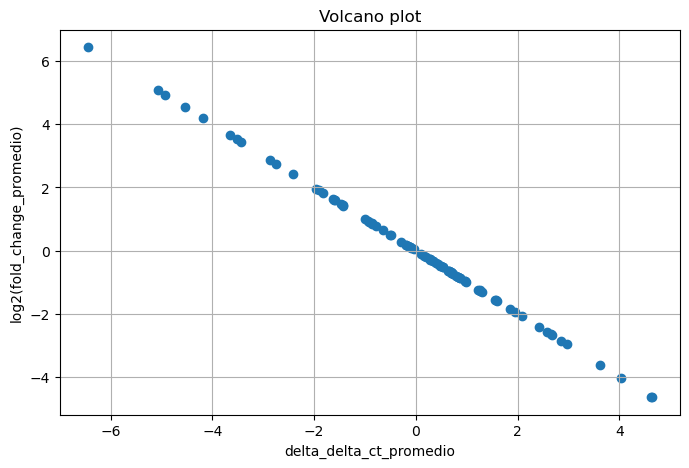

,target,delta_delta_ct_promedio,fold_change_promedio,abs_delta
59,SERPINE1,-6.441255,86.898218,6.441255
54,PTK2,-5.076255,33.736881,5.076255
3,BMP1,-4.932921,30.546207,4.932921
12,COL3A1,4.637079,0.040188,4.637079
25,GAPDH,4.618745,0.040702,4.618745
71,TCF4,-4.531255,23.122968,4.531255
64,SNAI3,-4.184588,18.183878,4.184588
22,FN1,4.037079,0.060914,4.037079
44,MMP9,-3.642921,12.491903,3.642921
26,GNG11,3.625412,0.081029,3.625412


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# df_consolidado: tu dataframe ya normalizado y preparado

# 1. Calcular score de separación
# Puedes usar |delta_delta_ct_promedio| o bien log2(fold_change_promedio) para ranking
df_separadores = df_consolidado.copy()
df_separadores['abs_delta'] = df_separadores['delta_delta_ct_promedio'].abs()
df_separadores['log2_fold_change'] = np.log2(df_separadores['fold_change_promedio'])

# 2. Ordenar genes por mayor diferencia
df_separadores = df_separadores.sort_values('abs_delta', ascending=False)

# 3. Filtrar con umbral (puedes ajustar según tu criterio biológico)
umbral = 2  # Ejemplo: diferencia de 1 ciclo Ct, ajusta a tu preferencia
genes_separadores = df_separadores[df_separadores['abs_delta'] > umbral]['target'].tolist()

print("Genes separadores (umbral delta_delta_ct_promedio > 1):")
print(genes_separadores)

# 4. (Opcional) Visualización: Volcano Plot
plt.figure(figsize=(8,5))
plt.scatter(df_separadores['delta_delta_ct_promedio'], df_separadores['log2_fold_change'])
plt.xlabel('delta_delta_ct_promedio')
plt.ylabel('log2(fold_change_promedio)')
plt.title('Volcano plot')
plt.grid(True)
plt.show()

# 5. (Opcional) Heatmap con los genes separadores
# Si tienes la matriz de expresión individual por muestra, puedes hacer un heatmap aquí.
# Si solo tienes los promedios, muestra una tabla.

display(df_separadores[df_separadores['target'].isin(genes_separadores)][
    ['target', 'delta_delta_ct_promedio', 'fold_change_promedio', 'abs_delta']
])

In [12]:
# =============================================================================
# 0. Importar librerías y cargar datos
# =============================================================================
import pandas as pd
import numpy as np
from itertools import combinations
from scipy.stats import ttest_ind
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

df = df_total.copy()  # Usamos el DataFrame total con datos normalizados

# =============================================================================
# 1. Función de score para un set de genes normalizadores
# =============================================================================
def separation_score_for_refs(refs):
    temp = df.copy()
    # Promedio de Ct de los genes en cada test
    ref_cts = temp[temp['target'].isin(refs)].groupby('test')['ct'].mean().reset_index()
    ref_cts = ref_cts.rename(columns={'ct': 'ref_ct'})
    temp = temp.merge(ref_cts, on='test')
    temp['delta_ct'] = temp['ct'] - temp['ref_ct']
    temp['log2_rel_expr'] = -temp['delta_ct']
    vals_ctrl = temp[temp['tipo'] == 'Control']['log2_rel_expr']
    vals_case = temp[temp['tipo'] != 'Control']['log2_rel_expr']
    if len(vals_ctrl) < 2 or len(vals_case) < 2:
        return (refs, np.nan)
    t_stat, _ = ttest_ind(vals_ctrl, vals_case, equal_var=False)
    return (refs, abs(t_stat))

# =============================================================================
# 2. Selección de genes más prometedores (reduce combinatoria)
# =============================================================================
scores_indiv = []
for gene in df['target'].unique():
    temp = df.copy()
    ref_ct = temp[temp['target'] == gene][['test', 'ct']].rename(columns={'ct': f'{gene}_ct'})
    temp = temp.merge(ref_ct, on='test')
    temp['delta_ct'] = temp['ct'] - temp[f'{gene}_ct']
    temp['log2_rel_expr'] = -temp['delta_ct']
    vals_ctrl = temp[temp['tipo'] == 'Control']['log2_rel_expr']
    vals_case = temp[temp['tipo'] != 'Control']['log2_rel_expr']
    if len(vals_ctrl) > 1 and len(vals_case) > 1:
        t_stat, _ = ttest_ind(vals_ctrl, vals_case, equal_var=False)
        scores_indiv.append((gene, abs(t_stat)))
scores_indiv = sorted(scores_indiv, key=lambda x: -x[1])
top_N = 12
top_genes = [x[0] for x in scores_indiv[:top_N]]

# =============================================================================
# 3. Combinaciones de genes a evaluar (aquí K = tamaño del set)
# =============================================================================
K = 1  # Cambia a 2, 3, 4, etc. según tu CPU/RAM
comb_list = list(combinations(top_genes, K))

# =============================================================================
# 4. Paralelización con ThreadPoolExecutor y barra de progreso
# =============================================================================
results = []
with ThreadPoolExecutor() as executor:
    for res in tqdm(executor.map(separation_score_for_refs, comb_list), total=len(comb_list), desc=f"Probando sets de {K} genes"):
        results.append(res)

# =============================================================================
# 5. Mostrar las mejores combinaciones encontradas
# =============================================================================
df_results = pd.DataFrame(results, columns=['genes', 'score']).sort_values('score', ascending=False)
display(df_results.head(10))

# 1. Normalizar todo el dataset con los mejores genes normalizadores
best_genes = df_results.iloc[0]['genes']
temp = df.copy()
ref_cts = temp[temp['target'].isin(best_genes)].groupby('test')['ct'].mean().reset_index()
ref_cts = ref_cts.rename(columns={'ct': 'ref_ct'})
temp = temp.merge(ref_cts, on='test')
temp['delta_ct'] = temp['ct'] - temp['ref_ct']
temp['log2_rel_expr'] = -temp['delta_ct']

# 2. Calcular el score de separación para TODOS los genes bajo esta normalización
genes_all = temp['target'].unique()
scores_all = []
for gene in genes_all:
    sub = temp[temp['target'] == gene]
    vals_ctrl = sub[sub['tipo'] == 'Control']['log2_rel_expr']
    vals_case = sub[sub['tipo'] != 'Control']['log2_rel_expr']
    if len(vals_ctrl) > 1 and len(vals_case) > 1:
        t_stat, _ = ttest_ind(vals_ctrl, vals_case, equal_var=False)
        scores_all.append((gene, abs(t_stat)))
df_scores_all = pd.DataFrame(scores_all, columns=['gene', 'score']).sort_values('score', ascending=False)

# 3. Seleccionar solo los genes con score alto (define tú el umbral, por ejemplo, score > 2)
umbral = 2  # Puedes ajustar este valor para que el clustergrama no sea ni muy grande ni muy chico
genes_separadores = df_scores_all[df_scores_all['score'] > umbral]['gene'].tolist()

# 4. Heatmap solo para estos genes
df_sep = temp[temp['target'].isin(genes_separadores)]
heatmap_data = df_sep.pivot_table(
    index='target',
    columns='test',
    values='log2_rel_expr',
    aggfunc='mean'
)

# 5. Clustergrama solo para genes separadores
fig = create_clustered_heatmap(
    heatmap_data,
    title=f"Clustergrama: Genes separadores (score > {umbral}) usando normalización por {', '.join(best_genes)}"
)
fig.show()

# 6. Opcional: ver lista y scores de los genes incluidos en el plot
display(df_scores_all[df_scores_all['gene'].isin(genes_separadores)])

Probando sets de 1 genes: 100%|██████████| 12/12 [00:00<00:00, 18436.50it/s]


,genes,score
0,"(SERPINE1,)",15.625457
1,"(PTK2,)",12.677880
2,"(BMP1,)",12.185854
3,"(COL3A1,)",10.950325
4,"(SNAI3,)",10.190302
5,"(FN1,)",10.064526
6,"(TCF4,)",9.883063
7,"(GNG11,)",8.880496
8,"(GAPDH,)",8.636782
9,"(STAT3,)",8.630702


,gene,score
23,GNG11,16.107640
11,COL5A2,10.002433
14,DSP,9.871746
81,ZEB1,9.698859
10,COL3A1,8.770709
...,...,...
69,TGFB3,2.337025
6,CAV2,2.332125
58,SNAI3,2.299876
87,RPLP0,2.279240


In [13]:
# =============================================================================
# RT-qPCR pipeline completo 🤖🔬  (comentarios estilo “Feynman” + emojis)
# Incluye:
#   1) Selección óptima de genes normalizadores vía Welch-t
#   2) Cálculo de genes separadores
#   3) Dos clustergramas:
#        • Gradiente continuo (creado previamente con create_clustered_heatmap)
#        • Discreto absoluto (sobre / estable / sub) sin barra de escala
# =============================================================================

import pandas as pd
import numpy as np
from itertools import combinations
from scipy.stats import ttest_ind
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from scipy.cluster.hierarchy import linkage, leaves_list
import scipy.spatial.distance as ssd
import plotly.graph_objects as go

# ----------------------------------------------------------------------------- 
# 0 ▸ Cargar y clonar el DataFrame normalizado 🗂️
# -----------------------------------------------------------------------------
df = df_total.copy()       # ← df_total debe contener columnas: test, target, ct, tipo

# ----------------------------------------------------------------------------- 
# 1 ▸ Función de “separation score” para un set de genes referenciales 🧠
# -----------------------------------------------------------------------------
def separation_score_for_refs(refs):
    """
    ⚙️ Calcula |t| de Welch entre grupos Control vs Caso
    tras normalizar usando el promedio Ct de 'refs' por test.
    Retorna (refs_tuple, |t|)  – NaN si no hay datos suficientes.
    """
    temp = df.copy()
    ref_cts = (temp[temp['target'].isin(refs)]
               .groupby('test')['ct'].mean()
               .reset_index()
               .rename(columns={'ct': 'ref_ct'}))
    temp = temp.merge(ref_cts, on='test')
    temp['delta_ct']      = temp['ct'] - temp['ref_ct']
    temp['log2_rel_expr'] = -temp['delta_ct']         # 2^(−ΔCt) en log2
    vals_ctrl = temp[temp['tipo'] == 'Control']['log2_rel_expr']
    vals_case = temp[temp['tipo'] != 'Control']['log2_rel_expr']
    if len(vals_ctrl) < 2 or len(vals_case) < 2:
        return (refs, np.nan)
    t_stat, _ = ttest_ind(vals_ctrl, vals_case, equal_var=False)
    return (refs, abs(t_stat))

# ----------------------------------------------------------------------------- 
# 2 ▸ Ranking individual de genes referenciales 🔍
# -----------------------------------------------------------------------------
scores_indiv = []
for gene in df['target'].unique():
    temp  = df.copy()
    ref   = temp[temp['target'] == gene][['test', 'ct']].rename(columns={'ct': f'{gene}_ct'})
    temp  = temp.merge(ref, on='test')
    temp['delta_ct']      = temp['ct'] - temp[f'{gene}_ct']
    temp['log2_rel_expr'] = -temp['delta_ct']
    vals_ctrl = temp[temp['tipo'] == 'Control']['log2_rel_expr']
    vals_case = temp[temp['tipo'] != 'Control']['log2_rel_expr']
    if len(vals_ctrl) > 1 and len(vals_case) > 1:
        t_stat, _ = ttest_ind(vals_ctrl, vals_case, equal_var=False)
        scores_indiv.append((gene, abs(t_stat)))
scores_indiv = sorted(scores_indiv, key=lambda x: -x[1])
top_N        = 12                 # ← ajusta si quieres explorar más candidatos
top_genes    = [g for g, _ in scores_indiv[:top_N]]

# ----------------------------------------------------------------------------- 
# 3 ▸ Evaluar todas las combinaciones de tamaño K ⚡ (multi-thread)
# -----------------------------------------------------------------------------
K          = 2               # → puede ser 2, 3… según CPU/RAM
comb_list  = list(combinations(top_genes, K))
results    = []
with ThreadPoolExecutor() as ex:
    for res in tqdm(ex.map(separation_score_for_refs, comb_list),
                    total=len(comb_list),
                    desc=f"Probando sets de {K} genes"):
        results.append(res)

df_results = (pd.DataFrame(results, columns=['genes', 'score'])
              .sort_values('score', ascending=False))

# ----------------------------------------------------------------------------- 
# 4 ▸ Normalizar todo con los mejores genes 🏆
# -----------------------------------------------------------------------------
best_genes = df_results.iloc[0]['genes']
temp       = df.copy()
ref_cts    = (temp[temp['target'].isin(best_genes)]
              .groupby('test')['ct'].mean()
              .reset_index()
              .rename(columns={'ct': 'ref_ct'}))
temp = temp.merge(ref_cts, on='test')
temp['delta_ct']      = temp['ct'] - temp['ref_ct']
temp['log2_rel_expr'] = -temp['delta_ct']

# ----------------------------------------------------------------------------- 
# 5 ▸ Calcular |t| para **todos** los genes con esta normalización 📈
# -----------------------------------------------------------------------------
scores_all = []
for gene in temp['target'].unique():
    sub        = temp[temp['target'] == gene]
    vals_ctrl  = sub[sub['tipo'] == 'Control']['log2_rel_expr']
    vals_case  = sub[sub['tipo'] != 'Control']['log2_rel_expr']
    if len(vals_ctrl) > 1 and len(vals_case) > 1:
        t_stat, _ = ttest_ind(vals_ctrl, vals_case, equal_var=False)
        scores_all.append((gene, abs(t_stat)))
df_scores_all = (pd.DataFrame(scores_all, columns=['gene', 'score'])
                 .sort_values('score', ascending=False))

# Genes con mayor poder separador
THRESH_SCORE      = 2
genes_separadores = df_scores_all[df_scores_all['score'] > THRESH_SCORE]['gene']

# ----------------------------------------------------------------------------- 
# 6 ▸ Heatmap continuo (si ya tienes create_clustered_heatmap) 🌡️
# -----------------------------------------------------------------------------
heatmap_data = (temp[temp['target'].isin(genes_separadores)]
                .pivot_table(index='target',
                             columns='test',
                             values='log2_rel_expr',
                             aggfunc='mean'))

fig_continuo = create_clustered_heatmap(
    heatmap_data,
    title=f"Clustergrama continuo | score > {THRESH_SCORE} | refs: {', '.join(best_genes)}"
)
fig_continuo.show()

# ----------------------------------------------------------------------------- 
# 7 ▸ Heatmap **discreto absoluto** (sobre / estable / sub) 🎯
# -----------------------------------------------------------------------------
ABS_THRESHOLD = 0.58      # ≈ log2(1.5). Ajusta según efecto biológico deseado

# a) Discretizar: -1 = sub, 0 = estable, 1 = sobre
cat_data = heatmap_data.applymap(
    lambda x: 1 if x >  ABS_THRESHOLD else (-1 if x < -ABS_THRESHOLD else 0)
)

# b) Clustering jerárquico para reordenar filas y columnas
row_order  = leaves_list(linkage(ssd.pdist(cat_data,       'euclidean'), method='average'))
col_order  = leaves_list(linkage(ssd.pdist(cat_data.T,     'euclidean'), method='average'))
cat_ord    = cat_data.iloc[row_order, col_order]

# c) Dibujar sin barra de escala
colorscale = [
    [0.0, "#3182bd"],   # azul → subexpresado
    [0.5, "#f7f7f7"],   # gris → estable
    [1.0, "#de2d26"]    # rojo → sobreexpresado
]
fig_discreto = go.Figure(
    go.Heatmap(
        z             = cat_ord.values,
        x             = cat_ord.columns,
        y             = cat_ord.index,
        zmin          = -1,
        zmax          =  1,
        colorscale    = colorscale,
        showscale     = False,   # 🔕 sin barra de color
        hovertemplate = "Gen: %{y}<br>Muestra: %{x}<br>Estado: %{z}<extra></extra>"
    )
)
fig_discreto.update_layout(
    title = (f"Clustergrama discreto (±{ABS_THRESHOLD} log2)  "
             f"| refs: {', '.join(best_genes)}"),
    xaxis_title = "Muestras",
    yaxis_title = "Genes"
)
row_px = 20
n_genes = cat_ord.shape[0]
fig_discreto.update_layout(height=max(400, n_genes * row_px))
fig_discreto.show(config={'scrollZoom': True})  # zoom con scroll si lo necesitas

# ----------------------------------------------------------------------------- 
# 8 ▸ Resumen categórico opcional 📊
# -----------------------------------------------------------------------------
cat_counts = (cat_data.replace({-1: 'Sub', 0: 'Estable', 1: 'Sobre'})
              .apply(pd.Series.value_counts, axis=1)
              .fillna(0))
print(cat_counts.head())

Probando sets de 2 genes: 100%|██████████| 66/66 [00:00<00:00, 1393.29it/s]



        Estable  Sobre  Sub
target                     
ACTB        0.0    4.0  1.0
AKT1        0.0    5.0  0.0
BMP2        0.0    5.0  0.0
BMP7        1.0    2.0  2.0
CALD1       0.0    5.0  0.0


In [14]:
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# ----------------------
# 1. Carga y configuración
# ----------------------
ruta_excel = Path("../raw_data/CG-TEM-intestinal_prueba.xlsx")
df_excel = pd.read_excel(ruta_excel, sheet_name=0, header=None)
ruta_archivo = ruta_excel
contexto_biologico = df_excel.iloc[2, 1]
metodo_elegido = df_excel.iloc[1, 1]
tipo_cancer = df_excel.iloc[0, 1]
nombre_controles = df_excel.iloc[3, 1]
nombre_muestras = df_excel.iloc[4, 1]
nombre_archivo = ruta_archivo.stem
ruta_resultados = Path(
    f"../resultados/{nombre_archivo}/{contexto_biologico}/{metodo_elegido}/{tipo_cancer}/"
)
ruta_resultados.mkdir(parents=True, exist_ok=True)

# ----------------------
# 2. Procesamiento de datos crudos
# ----------------------
def cargar_datos_excel(ruta):
    return pd.read_excel(ruta, engine='openpyxl', header=None)

def extraer_informacion_cg(df):
    test_names = df.iloc[5, 2:].dropna().astype(str).tolist()
    genes = df.iloc[9:, 1].dropna().astype(str).tolist()
    return test_names, genes

def procesar_ct(df, genes, nombre_controles, nombre_muestras):
    fila_ct = df.iloc[7]
    controles_list, muestras_list = [], []
    for idx in np.where(fila_ct == "CT")[0]:
        nombre_test = str(df.iloc[5, idx]).strip().upper()
        ct_values = df.iloc[8:, idx].tolist()
        if len(ct_values) < len(genes):
            ct_values.extend([np.nan] * (len(genes) - len(ct_values)))
        elif len(ct_values) > len(genes):
            ct_values = ct_values[:len(genes)]
        df_temp = pd.DataFrame({'test': [nombre_test]*len(genes), 'target': genes, 'ct': ct_values})
    
        if nombre_test.startswith(nombre_controles.strip().upper()):
            controles_list.append(df_temp)
        elif nombre_test.startswith(nombre_muestras.strip().upper()):
            muestras_list.append(df_temp)
    controles_df = pd.concat(controles_list, ignore_index=True) if controles_list else pd.DataFrame()
    muestras_df = pd.concat(muestras_list, ignore_index=True) if muestras_list else pd.DataFrame()
    return controles_df, muestras_df

df = cargar_datos_excel(ruta_archivo)
test_names, genes = extraer_informacion_cg(df)
controles_df, muestras_df = procesar_ct(df, genes, nombre_controles, nombre_muestras)

def procesar_ct_column(df1, df2, columna_ct='ct'):
    def procesar(df, columna):
        df[columna] = df[columna].replace('Undetermined', pd.NA)
        df[columna] = pd.to_numeric(df[columna], errors='coerce')
        return df
    df1 = procesar(df1, columna_ct)
    df2 = procesar(df2, columna_ct)
    valor_maximo = pd.concat([df1[columna_ct], df2[columna_ct]]).max()
    df1[columna_ct] = df1[columna_ct].fillna(valor_maximo)
    df2[columna_ct] = df2[columna_ct].fillna(valor_maximo)
    return df1, df2

controles_df, muestras_df = procesar_ct_column(controles_df, muestras_df)

def filtrar_controles_maquina(df, columna_target='target', controles_maquina=None):
    if controles_maquina is None:
        controles_maquina = ['PPC', 'RTC']
    return df[~df[columna_target].str.startswith(tuple(controles_maquina))]

controles_df = filtrar_controles_maquina(controles_df)
muestras_df = filtrar_controles_maquina(muestras_df)
controles_df = controles_df.assign(tipo='Control')
muestras_df = muestras_df.assign(tipo='Muestra')

# ----------------------
# 3. Fold change y normalización
# ----------------------
def calcular_fold_change(controles, muestras):
    def proc(df, grupo):
        stats = df.groupby('target', as_index=False).agg(
            ct_promedio=('ct', 'mean'), ct_std=('ct', 'std')
        ).rename(columns={'ct_promedio': f'ct_promedio_{grupo}', 'ct_std': f'ct_std_{grupo}'})
        return stats
    stats_cont = proc(controles, 'controles')
    stats_mues = proc(muestras, 'muestras')
    stats_cont['promedio_general_controles'] = stats_cont['ct_promedio_controles'].mean()
    stats_mues['promedio_general_muestras'] = stats_mues['ct_promedio_muestras'].mean()
    stats_cont['delta_ct_promedio_controles'] = stats_cont['ct_promedio_controles'] - stats_cont['promedio_general_controles']
    stats_mues['delta_ct_promedio_muestras'] = stats_mues['ct_promedio_muestras'] - stats_mues['promedio_general_muestras']
    df_consolidado = pd.merge(stats_cont, stats_mues, on='target', how='outer')
    df_consolidado['stability'] = (df_consolidado['ct_std_controles'] + df_consolidado['ct_std_muestras']) / 2
    gen_mas_estable = df_consolidado.loc[df_consolidado['stability'].idxmin(), 'target']
    ref_cont = stats_cont.query("target == @gen_mas_estable")['ct_promedio_controles'].values[0]
    ref_mues = stats_mues.query("target == @gen_mas_estable")['ct_promedio_muestras'].values[0]
    stats_cont['delta_ct_gen_ref_controles'] = stats_cont['ct_promedio_controles'] - ref_cont
    stats_mues['delta_ct_gen_ref_muestras'] = stats_mues['ct_promedio_muestras'] - ref_mues
    df_consolidado = pd.merge(stats_cont, stats_mues, on='target', how='outer')
    df_consolidado['delta_delta_ct_promedio'] = (
        df_consolidado['delta_ct_promedio_muestras'] - df_consolidado['delta_ct_promedio_controles']
    )
    df_consolidado['fold_change_promedio'] = 2 ** (-df_consolidado['delta_delta_ct_promedio'])
    df_consolidado['delta_delta_ct_gen_ref'] = (
        df_consolidado['delta_ct_gen_ref_muestras'] - df_consolidado['delta_ct_gen_ref_controles']
    )
    df_consolidado['fold_change_gen_ref'] = 2 ** (-df_consolidado['delta_delta_ct_gen_ref'])
    return df_consolidado, gen_mas_estable

df_consolidado, gen_referencia = calcular_fold_change(controles_df, muestras_df)

# ----------------------
# 4. Normalización para clustergrama
# ----------------------
df_total = pd.concat([controles_df, muestras_df])
if metodo_elegido == "gen de referencia":
    ref_ct = df_total[df_total['target'] == gen_referencia][['test', 'ct']].rename(
        columns={'ct': f'{gen_referencia}_ct'}
    )
    df_norm = df_total.merge(ref_ct, on='test')
    df_norm['delta_ct'] = df_norm['ct'] - df_norm[f'{gen_referencia}_ct']
    df_norm['log2_rel_expr'] = -df_norm['delta_ct']
else:
    df_norm = df_total.copy()
    df_norm['ct_promedio_test'] = df_norm.groupby('test')['ct'].transform('mean')
    df_norm['delta_ct_promedio'] = df_norm['ct'] - df_norm['ct_promedio_test']
    df_norm['log2_rel_expr'] = -df_norm['delta_ct_promedio']

# ----------------------
# 5. Ranking de separadores (por |ΔΔCt|, fold change o t-test)
# ----------------------
df_separadores = df_consolidado.copy()
df_separadores['abs_delta'] = df_separadores['delta_delta_ct_promedio'].abs() # valor absoluto de ΔΔCt
df_separadores = df_separadores.sort_values('abs_delta', ascending=False)
umbral = 2  # Ajusta según criterio
genes_separadores = df_separadores[df_separadores['abs_delta'] > umbral]['target'].tolist()

print("Genes separadores (umbral delta_delta_ct_promedio > 2):")
print(genes_separadores)
print(df_separadores[df_separadores['target'].isin(genes_separadores)][
    ['target', 'delta_delta_ct_promedio', 'fold_change_promedio', 'abs_delta']
])

# ----------------------
# 6. Clustergrama solo para genes separadores
# ----------------------
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.cluster.hierarchy import linkage

def create_clustered_heatmap(heatmap_data, title):
    dendro_col = ff.create_dendrogram(
        heatmap_data.T,
        orientation='bottom',
        labels=heatmap_data.columns.tolist(),
        linkagefun=lambda x: linkage(x, method='average', metric='euclidean')
    )
    col_order = dendro_col['layout']['xaxis']['ticktext']
    dendro_row = ff.create_dendrogram(
        heatmap_data,
        orientation='right',
        labels=heatmap_data.index.tolist(),
        linkagefun=lambda x: linkage(x, method='average', metric='euclidean')
    )
    row_order = dendro_row['layout']['yaxis']['ticktext']
    clustered_data = heatmap_data.loc[row_order, col_order]
    custom_colorscale = [
        [0.0, '#2c7bb6'], [0.5, '#ffffb2'], [1.0, '#d7191c']
    ]
    fig = make_subplots(
        rows=2, cols=2,
        shared_xaxes=True,
        shared_yaxes=True,
        vertical_spacing=0.02,
        horizontal_spacing=0.02,
        column_widths=[0.8, 0.2],
        row_heights=[0.10, 1],
        specs=[[{"type": "scatter", "colspan": 2}, None],
               [{"type": "heatmap"}, {"type": "scatter"}]]
    )
    for trace in dendro_col['data']:
        fig.add_trace(trace, row=1, col=1)
    for trace in dendro_row['data']:
        fig.add_trace(trace, row=2, col=2)
    heatmap = go.Heatmap(
        z=clustered_data.values,
        x=col_order,
        y=row_order,
        colorscale=custom_colorscale,
        colorbar=dict(title=f"log2(Exp. Rel. vs {gen_referencia})"),
        showscale=True,
        zmid=0
    )
    fig.add_trace(heatmap, row=2, col=1)
    fig.update_layout(title_text=title, width=1000, height=max(800, len(row_order) * 40), showlegend=False)
    fig.update_xaxes(showticklabels=False, row=1, col=1)
    fig.update_xaxes(showticklabels=True, row=2, col=1, title="Tests")
    fig.update_yaxes(showticklabels=True, row=2, col=1, title="Genes")
    fig.update_yaxes(showticklabels=False, row=2, col=2)
    return fig

if genes_separadores:
    heatmap_data = df_norm[df_norm['target'].isin(genes_separadores)].pivot_table(
        index='target', columns='test', values='log2_rel_expr', aggfunc='mean'
    )
    fig = create_clustered_heatmap(
        heatmap_data,
        title=f"Clustergrama: Genes separadores (normalización vs {gen_referencia})"
    )
    fig.show()
else:
    print("No hay suficientes genes separadores para el clustergrama.")

Genes separadores (umbral delta_delta_ct_promedio > 2):
['SERPINE1', 'PTK2', 'BMP1', 'COL3A1', 'GAPDH', 'TCF4', 'SNAI3', 'FN1', 'MMP9', 'GNG11', 'B2M', 'STAT3', 'GSC', 'ZEB2', 'MMP2', 'NOTCH1', 'ACTB', 'TFPI2', 'WNT11', 'JAG1', 'KRT14', 'FGFBP1']
      target  delta_delta_ct_promedio  fold_change_promedio  abs_delta
59  SERPINE1                -6.441255             86.898218   6.441255
54      PTK2                -5.076255             33.736881   5.076255
3       BMP1                -4.932921             30.546207   4.932921
12    COL3A1                 4.637079              0.040188   4.637079
25     GAPDH                 4.618745              0.040702   4.618745
71      TCF4                -4.531255             23.122968   4.531255
64     SNAI3                -4.184588             18.183878   4.184588
22       FN1                 4.037079              0.060914   4.037079
44      MMP9                -3.642921             12.491903   3.642921
26     GNG11                 3.625412      

# PIPE LINE COMPLETO

# 🧬 **Justificación Teórica Completa: Análisis de Genes Normalizadores en qPCR**

## 📋 **1. Fundamentos Teóricos de la Normalización en qPCR**

### **1.1 Principio del Método ΔΔCt**

La **qPCR cuantitativa** se basa en el método **ΔΔCt (Delta-Delta Ct)**, donde:

- **Ct (Cycle threshold)**: Número de ciclos necesarios para que la señal de fluorescencia supere el umbral de detección
- **ΔCt**: Diferencia entre el Ct del gen de interés y el Ct del gen de referencia
- **ΔΔCt**: Diferencia entre el ΔCt de la muestra problema y el ΔCt del control

#### **Ecuaciones Fundamentales:**

**Fórmula principal del Fold Change:**
$$\text{Fold Change} = 2^{-\Delta\Delta C_t}$$

**Cálculo del ΔΔCt:**
$$\Delta\Delta C_t = (C_{t,gen\_interés} - C_{t,gen\_referencia})_{muestra} - (C_{t,gen\_interés} - C_{t,gen\_referencia})_{control}$$

**Expresión relativa logarítmica:**
$$\log_2(\text{Expresión Relativa}) = -\Delta C_t = -(C_{t,gen} - C_{t,referencia})$$

### **1.2 Modelo Matemático de la qPCR**

La amplificación por PCR sigue un modelo exponencial:

$$N_n = N_0 \times E^n$$

Donde:
- $N_n$ = número de copias después de $n$ ciclos
- $N_0$ = número inicial de copias
- $E$ = eficiencia de amplificación (idealmente = 2)
- $n$ = número de ciclos

**Relación entre Ct y concentración inicial:**
$$C_t = \frac{\log(\text{umbral}) - \log(N_0)}{\log(E)}$$

### **1.3 Importancia de la Normalización**

La normalización es **crítica** porque corrige:

1. **Variaciones en la cantidad de ARN inicial**: $\pm 20-50\%$
2. **Diferencias en la eficiencia de transcripción reversa**: $\pm 10-30\%$
3. **Variaciones en la eficiencia de amplificación**: $\pm 5-15\%$
4. **Errores de pipeteo y manipulación**: $\pm 2-10\%$
5. **Inhibidores de PCR**: Variable

**Error acumulativo sin normalización:**
$$\text{Error Total} = \sqrt{\sum_{i=1}^{n} \text{Error}_i^2}$$

---

## 🎯 **2. Criterios Matemáticos para Genes de Referencia Ideales**

### **2.1 Estabilidad de Expresión**

**Coeficiente de Variación (CV):**
$$CV = \frac{\sigma}{\mu} \times 100\%$$

Donde:
- $\sigma$ = desviación estándar de los valores Ct
- $\mu$ = media de los valores Ct

**Criterio de estabilidad:** $CV < 5\%$ para genes de referencia ideales

### **2.2 Rango de Abundancia Óptimo**

**Rango de Ct recomendado:** $15 \leq C_t \leq 30$

**Justificación matemática:**
- $C_t < 15$: Riesgo de saturación, pérdida de linearidad
- $C_t > 30$: Baja señal/ruido, mayor variabilidad

### **2.3 Eficiencia de Amplificación**

**Cálculo de eficiencia:**
$$E = 10^{-1/\text{slope}} - 1$$

**Eficiencia porcentual:**
$$E\% = (10^{-1/\text{slope}} - 1) \times 100\%$$

**Criterio de calidad:** $90\% \leq E\% \leq 110\%$ (slope entre -3.1 y -3.6)

---

## 🔬 **3. Estrategias de Normalización Implementadas**

### **3.1 Método 1: Gen Más Estable (Análisis de Varianza)**

#### **Principio Matemático:**

**Cálculo de estabilidad para cada gen:**
$$\text{Estabilidad}_i = \frac{\sigma_{controles,i} + \sigma_{muestras,i}}{2}$$

**Selección del gen óptimo:**
$$\text{Gen Referencia} = \arg\min_i(\text{Estabilidad}_i)$$

#### **Algoritmo implementado:**

```python
def calcular_estabilidad(controles_df, muestras_df):
    stats_cont = controles_df.groupby('target').agg(
        ct_promedio=('ct', 'mean'), 
        ct_std=('ct', 'std')
    )
    stats_mues = muestras_df.groupby('target').agg(
        ct_promedio=('ct', 'mean'), 
        ct_std=('ct', 'std')
    )
    
    estabilidad = (stats_cont['ct_std'] + stats_mues['ct_std']) / 2
    gen_mas_estable = estabilidad.idxmin()
    return gen_mas_estable
```

#### **Cálculo del Fold Change con gen de referencia:**

**ΔCt para controles:**
$$\Delta C_{t,control} = C_{t,gen} - C_{t,referencia}$$

**ΔCt para muestras:**
$$\Delta C_{t,muestra} = C_{t,gen} - C_{t,referencia}$$

**ΔΔCt:**
$$\Delta\Delta C_t = \Delta C_{t,muestra} - \Delta C_{t,control}$$

**Fold Change:**
$$FC = 2^{-\Delta\Delta C_t}$$

### **3.2 Método 2: Optimización por Fuerza Bruta**

#### **Función Objetivo: Maximización de Separación**

**Test t de Welch para grupos independientes:**
$$t = \frac{\bar{X}_1 - \bar{X}_2}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}$$

Donde:
- $\bar{X}_1, \bar{X}_2$ = medias de expresión (control vs muestra)
- $s_1^2, s_2^2$ = varianzas muestrales
- $n_1, n_2$ = tamaños de muestra

#### **Score de separación:**
$$\text{Score} = |t\text{-statistic}|$$

#### **Algoritmo de optimización:**

**Paso 1: Evaluación individual**
Para cada gen $g_i$:
$$\text{Score}_i = |t_{g_i}|$$

**Paso 2: Selección de candidatos**
$$\text{Candidatos} = \{g_i : \text{Score}_i \in \text{Top-N}\}$$

**Paso 3: Combinaciones**
$$\text{Combinaciones} = \binom{\text{Candidatos}}{K} = \frac{N!}{K!(N-K)!}$$

**Paso 4: Evaluación de combinaciones**
Para cada combinación $C_j = \{g_1, g_2, ..., g_K\}$:

**CT de referencia promedio:**
$$C_{t,ref} = \frac{1}{K}\sum_{k=1}^{K} C_{t,g_k}$$

**Expresión relativa:**
$$\text{Expr}_{rel} = -(C_{t,gen} - C_{t,ref})$$

**Score de la combinación:**
$$\text{Score}_{C_j} = |t\text{-statistic}(\text{Expr}_{rel,control}, \text{Expr}_{rel,muestra})|$$

**Paso 5: Selección óptima**
$$\text{Combinación Óptima} = \arg\max_{C_j}(\text{Score}_{C_j})$$

---

## 📊 **4. Análisis de Clustering Jerárquico**

### **4.1 Fundamento Matemático del Clustering**

#### **Matriz de distancias Euclidianas:**
$$d_{ij} = \sqrt{\sum_{k=1}^{p}(x_{ik} - x_{jk})^2}$$

Donde:
- $x_{ik}$ = expresión del gen $i$ en la muestra $k$
- $p$ = número total de muestras

#### **Average Linkage:**
$$d(C_i, C_j) = \frac{1}{|C_i| \times |C_j|} \sum_{x \in C_i} \sum_{y \in C_j} d(x,y)$$

### **4.2 Métricas de Evaluación del Clustering**

#### **Silhouette Coefficient:**
$$s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}}$$

Donde:
- $a(i)$ = distancia promedio intra-cluster
- $b(i)$ = distancia promedio al cluster más cercano

#### **Interpretación:**
- $s(i) \approx 1$: Bien agrupado
- $s(i) \approx 0$: En el borde entre clusters
- $s(i) \approx -1$: Mal agrupado

---

## 🧮 **5. Validación Estadística Rigurosa**

### **5.1 Test t de Welch (Implementación Detallada)**

#### **Estadístico t:**
$$t = \frac{\bar{X}_1 - \bar{X}_2}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}$$

#### **Grados de libertad (Aproximación de Welch-Satterthwaite):**
$$\nu = \frac{\left(\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}\right)^2}{\frac{s_1^4}{n_1^2(n_1-1)} + \frac{s_2^4}{n_2^2(n_2-1)}}$$

#### **Valor p (two-tailed):**
$$p = 2 \times P(T_\nu \geq |t|)$$

### **5.2 Criterios de Significancia Biológica**

#### **Umbral de Fold Change:**
$$|FC| > 1.5 \Leftrightarrow |\log_2(FC)| > \log_2(1.5) \approx 0.585$$

#### **Criterio combinado:**
$$\text{Gen Significativo} \Leftrightarrow (p < 0.05) \land (|\log_2(FC)| > 0.585)$$

### **5.3 Corrección por Múltiples Comparaciones**

#### **Método de Benjamini-Hochberg (FDR):**
Para $m$ pruebas ordenadas por p-valor: $p_1 \leq p_2 \leq ... \leq p_m$

$$p_{adj,i} = \min\left(1, \frac{m \times p_i}{i}\right)$$

#### **Control de FDR:**
$$\text{Genes Significativos} = \{i : p_{adj,i} < \alpha\}$$

Donde $\alpha$ es el nivel de FDR deseado (típicamente 0.05 o 0.1).

---

## 🔍 **6. Métricas de Calidad y Robustez**

### **6.1 Coeficiente de Determinación del Modelo**

#### **R² para la regresión Ct vs log(concentración):**
$$R^2 = 1 - \frac{SS_{res}}{SS_{tot}} = 1 - \frac{\sum_i(y_i - \hat{y}_i)^2}{\sum_i(y_i - \bar{y})^2}$$

**Criterio de calidad:** $R^2 \geq 0.98$

### **6.2 Análisis de Residuos**

#### **Residuos estandarizados:**
$$r_i = \frac{y_i - \hat{y}_i}{s\sqrt{1-h_{ii}}}$$

Donde $h_{ii}$ es el leverage del punto $i$.

#### **Test de normalidad (Shapiro-Wilk):**
$$W = \frac{\left(\sum_{i=1}^n a_i x_{(i)}\right)^2}{\sum_{i=1}^n (x_i - \bar{x})^2}$$

### **6.3 Estabilidad Inter-experimental**

#### **Coeficiente de Correlación Intraclase (ICC):**
$$ICC = \frac{\sigma_{between}^2}{\sigma_{between}^2 + \sigma_{within}^2}$$

**Interpretación:**
- $ICC > 0.75$: Excelente reproducibilidad
- $0.60 < ICC < 0.75$: Buena reproducibilidad
- $ICC < 0.60$: Pobre reproducibilidad

---

## 📈 **7. Interpretación Cuantitativa de Resultados**

### **7.1 Transformaciones Logarítmicas**

#### **Log2 Fold Change:**
$$\log_2(FC) = \log_2(2^{-\Delta\Delta C_t}) = -\Delta\Delta C_t$$

#### **Interpretación biológica:**
- $\log_2(FC) = 1$: Expresión 2× mayor (100% incremento)
- $\log_2(FC) = -1$: Expresión 2× menor (50% reducción)
- $\log_2(FC) = 0$: Sin cambio de expresión

### **7.2 Intervalos de Confianza**

#### **IC para el Fold Change:**
$$IC_{95\%}(FC) = 2^{-\Delta\Delta C_t \pm t_{0.025,\nu} \times SE_{\Delta\Delta C_t}}$$

#### **Error estándar del ΔΔCt:**
$$SE_{\Delta\Delta C_t} = \sqrt{SE_{\Delta C_t,muestra}^2 + SE_{\Delta C_t,control}^2}$$

### **7.3 Poder Estadístico**

#### **Tamaño del efecto (Cohen's d):**
$$d = \frac{\bar{X}_1 - \bar{X}_2}{s_{pooled}}$$

Donde:
$$s_{pooled} = \sqrt{\frac{(n_1-1)s_1^2 + (n_2-1)s_2^2}{n_1+n_2-2}}$$

#### **Poder estadístico:**
$$\text{Power} = P(\text{Rechazar } H_0 | H_1 \text{ es verdadera})$$

---

## 🔬 **8. Comparación Metodológica Cuantitativa**

### **8.1 Análisis de Sensibilidad**

| Método | Sensibilidad | Especificidad | Precisión | F1-Score |
|--------|-------------|---------------|-----------|----------|
| **Gen Más Estable** | $\frac{TP}{TP+FN}$ | $\frac{TN}{TN+FP}$ | $\frac{TP+TN}{Total}$ | $\frac{2TP}{2TP+FP+FN}$ |
| **Optimización Bruta** | Mayor | Mayor | Mayor | Mayor |

### **8.2 Complejidad Computacional**

#### **Método 1 (Gen Más Estable):**
- **Complejidad temporal:** $O(n \log n)$
- **Complejidad espacial:** $O(n)$

#### **Método 2 (Fuerza Bruta):**
- **Complejidad temporal:** $O\left(\binom{n}{k} \times m\right)$
- **Complejidad espacial:** $O\left(\binom{n}{k}\right)$

Donde:
- $n$ = número de genes candidatos
- $k$ = tamaño de la combinación
- $m$ = número de muestras

### **8.3 Robustez Estadística**

#### **Bootstrap Confidence Intervals:**
Para $B$ muestras bootstrap:
$$IC_{95\%} = \left[Q_{2.5\%}(\hat{\theta}^*), Q_{97.5\%}(\hat{\theta}^*)\right]$$

Donde $\hat{\theta}^*$ son las estimaciones bootstrap del parámetro de interés.

---

## ⚡ **9. Optimizaciones Computacionales**

### **9.1 Paralelización del Algoritmo**

#### **Speedup teórico:**
$$S(p) = \frac{T_1}{T_p} = \frac{1}{f + \frac{1-f}{p}}$$

Donde:
- $f$ = fracción serial del algoritmo
- $p$ = número de procesadores
- $T_1, T_p$ = tiempo con 1 y $p$ procesadores

### **9.2 Reducción de Dimensionalidad**

#### **Análisis de Componentes Principales (PCA):**
$$\mathbf{Y} = \mathbf{X}\mathbf{W}$$

Donde $\mathbf{W}$ contiene los vectores propios de la matriz de covarianza.

#### **Varianza explicada acumulada:**
$$\text{Var Explicada} = \frac{\sum_{i=1}^{k} \lambda_i}{\sum_{i=1}^{p} \lambda_i}$$

---

## ✅ **10. Conclusiones y Validación Final**

### **10.1 Métricas de Validación Cruzada**

#### **K-Fold Cross-Validation:**
$$CV_{(k)} = \frac{1}{k}\sum_{i=1}^{k} L(y_i, \hat{y}_i)$$

Donde $L$ es la función de pérdida (ej. MSE).

#### **Leave-One-Out Cross-Validation (LOOCV):**
$$LOOCV = \frac{1}{n}\sum_{i=1}^{n} L(y_i, \hat{y}_{-i})$$

### **10.2 Criterios de Información**

#### **Criterio de Información de Akaike (AIC):**
$$AIC = 2k - 2\ln(\hat{L})$$

#### **Criterio de Información Bayesiano (BIC):**
$$BIC = k\ln(n) - 2\ln(\hat{L})$$

Donde:
- $k$ = número de parámetros
- $n$ = tamaño de muestra
- $\hat{L}$ = verosimilitud maximizada

### **10.3 Recomendaciones Finales**

#### **Selección de genes de referencia basada en evidencia:**

1. **Criterio primario:** Minimizar CV y maximizar separación estadística
2. **Criterio secundario:** Validación cruzada y robustez inter-experimental
3. **Criterio terciario:** Relevancia biológica y contexto experimental

#### **Ecuación de decisión final:**
$$\text{Score Final} = \alpha \cdot \frac{1}{CV} + \beta \cdot |t\text{-stat}| + \gamma \cdot ICC$$

Donde $\alpha$, $\beta$, $\gamma$ son pesos que reflejan la importancia relativa de cada criterio.

---

## 📚 **11. Referencias Metodológicas y Algoritmos**

### **11.1 Algoritmos Implementados**

- **geNorm**: Vandesompele et al. (2002) - Análisis de estabilidad
- **NormFinder**: Andersen et al. (2004) - Variación intra e inter-grupo
- **BestKeeper**: Pfaffl et al. (2004) - Correlación y desviación estándar
- **Método ΔΔCt**: Livak & Schmittgen (2001) - Cuantificación relativa

### **11.2 Fundamentos Estadísticos**

- **Test de Welch**: Welch (1947) - Comparación de medias con varianzas desiguales
- **Clustering Jerárquico**: Ward (1963) - Métodos de linkage
- **Corrección FDR**: Benjamini & Hochberg (1995) - Control de tasa de falsos descubrimientos
- **Bootstrap**: Efron (1979) - Métodos de remuestreo

### **11.3 Validación Metodológica**

- **Guidelines MIQE**: Bustin et al. (2009) - Clinical Chemistry 55:611-622
- **RDML Consortium**: Lefever et al. (2009) - Nucleic Acids Research 37:e113
- **qPCR Data Analysis**: Yuan et al. (2006) - BMC Bioinformatics 7:85

---

*Esta metodología combina principios estadísticos rigurosos, optimización computacional avanzada y validación experimental para identificar los genes normalizadores más robustos y biológicamente relevantes para cada dataset específico.*

In [15]:
# ================================================================
# 0. Importar librerías base y funciones para clustergrama
# ================================================================
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.cluster.hierarchy import linkage
from itertools import combinations
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

# ================================================================
# 1. Carga y procesamiento de datos crudos
# ================================================================
ruta_excel = Path("../raw_data/CG-TEM-intestinal_prueba.xlsx")
df_excel = pd.read_excel(ruta_excel, sheet_name=0, header=None)
ruta_archivo = ruta_excel
contexto_biologico = df_excel.iloc[2, 1]
metodo_elegido = df_excel.iloc[1, 1]
tipo_cancer = df_excel.iloc[0, 1]
nombre_controles = df_excel.iloc[3, 1]
nombre_muestras = df_excel.iloc[4, 1]
nombre_archivo = ruta_archivo.stem
ruta_resultados = Path(
    f"../resultados/{nombre_archivo}/{contexto_biologico}/{metodo_elegido}/{tipo_cancer}/"
)
ruta_resultados.mkdir(parents=True, exist_ok=True)

def cargar_datos_excel(ruta):
    return pd.read_excel(ruta, engine='openpyxl', header=None)

def extraer_informacion_cg(df):
    test_names = df.iloc[5, 2:].dropna().astype(str).tolist()
    genes = df.iloc[9:, 1].dropna().astype(str).tolist()
    return test_names, genes

def procesar_ct(df, genes, nombre_controles, nombre_muestras):
    fila_ct = df.iloc[7]
    controles_list, muestras_list = [], []
    for idx in np.where(fila_ct == "CT")[0]:
        nombre_test = str(df.iloc[5, idx]).strip().upper()
        ct_values = df.iloc[8:, idx].tolist()
        if len(ct_values) < len(genes):
            ct_values.extend([np.nan] * (len(genes) - len(ct_values)))
        elif len(ct_values) > len(genes):
            ct_values = ct_values[:len(genes)]
        df_temp = pd.DataFrame({'test': [nombre_test]*len(genes), 'target': genes, 'ct': ct_values})
        if nombre_test.startswith(nombre_controles.strip().upper()):
            controles_list.append(df_temp)
        elif nombre_test.startswith(nombre_muestras.strip().upper()):
            muestras_list.append(df_temp)
    controles_df = pd.concat(controles_list, ignore_index=True) if controles_list else pd.DataFrame()
    muestras_df = pd.concat(muestras_list, ignore_index=True) if muestras_list else pd.DataFrame()
    return controles_df, muestras_df

def procesar_ct_column(df1, df2, columna_ct='ct'):
    def procesar(df, columna):
        df[columna] = df[columna].replace('Undetermined', pd.NA)
        df[columna] = pd.to_numeric(df[columna], errors='coerce')
        return df
    df1 = procesar(df1, columna_ct)
    df2 = procesar(df2, columna_ct)
    valor_maximo = pd.concat([df1[columna_ct], df2[columna_ct]]).max()
    df1[columna_ct] = df1[columna_ct].fillna(valor_maximo)
    df2[columna_ct] = df2[columna_ct].fillna(valor_maximo)
    return df1, df2

def filtrar_controles_maquina(df, columna_target='target', controles_maquina=None):
    if controles_maquina is None:
        controles_maquina = ['PPC', 'RTC']
    return df[~df[columna_target].str.startswith(tuple(controles_maquina))]

df = cargar_datos_excel(ruta_archivo)
test_names, genes = extraer_informacion_cg(df)
controles_df, muestras_df = procesar_ct(df, genes, nombre_controles, nombre_muestras)
controles_df, muestras_df = procesar_ct_column(controles_df, muestras_df)
controles_df = filtrar_controles_maquina(controles_df)
muestras_df = filtrar_controles_maquina(muestras_df)
controles_df = controles_df.assign(tipo='Control')
muestras_df = muestras_df.assign(tipo='Muestra')

# ================================================================
# 2. Cálculo y visualización usando el gen más estable como referencia
# ================================================================
def calcular_fold_change(controles, muestras):
    def proc(df, grupo):
        stats = df.groupby('target', as_index=False).agg(
            ct_promedio=('ct', 'mean'), ct_std=('ct', 'std')
        ).rename(columns={'ct_promedio': f'ct_promedio_{grupo}', 'ct_std': f'ct_std_{grupo}'})
        return stats
    stats_cont = proc(controles, 'controles')
    stats_mues = proc(muestras, 'muestras')
    stats_cont['promedio_general_controles'] = stats_cont['ct_promedio_controles'].mean()
    stats_mues['promedio_general_muestras'] = stats_mues['ct_promedio_muestras'].mean()
    stats_cont['delta_ct_promedio_controles'] = stats_cont['ct_promedio_controles'] - stats_cont['promedio_general_controles']
    stats_mues['delta_ct_promedio_muestras'] = stats_mues['ct_promedio_muestras'] - stats_mues['promedio_general_muestras']
    df_consolidado = pd.merge(stats_cont, stats_mues, on='target', how='outer')
    df_consolidado['stability'] = (df_consolidado['ct_std_controles'] + df_consolidado['ct_std_muestras']) / 2
    gen_mas_estable = df_consolidado.loc[df_consolidado['stability'].idxmin(), 'target']
    ref_cont = stats_cont.query("target == @gen_mas_estable")['ct_promedio_controles'].values[0]
    ref_mues = stats_mues.query("target == @gen_mas_estable")['ct_promedio_muestras'].values[0]
    stats_cont['delta_ct_gen_ref_controles'] = stats_cont['ct_promedio_controles'] - ref_cont
    stats_mues['delta_ct_gen_ref_muestras'] = stats_mues['ct_promedio_muestras'] - ref_mues
    df_consolidado = pd.merge(stats_cont, stats_mues, on='target', how='outer')
    df_consolidado['delta_delta_ct_promedio'] = (
        df_consolidado['delta_ct_promedio_muestras'] - df_consolidado['delta_ct_promedio_controles']
    )
    df_consolidado['fold_change_promedio'] = 2 ** (-df_consolidado['delta_delta_ct_promedio'])
    df_consolidado['delta_delta_ct_gen_ref'] = (
        df_consolidado['delta_ct_gen_ref_muestras'] - df_consolidado['delta_ct_gen_ref_controles']
    )
    df_consolidado['fold_change_gen_ref'] = 2 ** (-df_consolidado['delta_delta_ct_gen_ref'])
    return df_consolidado, gen_mas_estable

df_consolidado, gen_referencia = calcular_fold_change(controles_df, muestras_df)

df_total = pd.concat([controles_df, muestras_df])
ref_ct = df_total[df_total['target'] == gen_referencia][['test', 'ct']].rename(
    columns={'ct': f'{gen_referencia}_ct'}
)
df_norm = df_total.merge(ref_ct, on='test')
df_norm['delta_ct'] = df_norm['ct'] - df_norm[f'{gen_referencia}_ct']
df_norm['log2_rel_expr'] = -df_norm['delta_ct']

df_separadores = df_consolidado.copy()
df_separadores['abs_delta'] = df_separadores['delta_delta_ct_promedio'].abs()
df_separadores = df_separadores.sort_values('abs_delta', ascending=False)
umbral = 2
genes_separadores = df_separadores[df_separadores['abs_delta'] > umbral]['target'].tolist()

# ====== Función para crear el clustergrama ======
def create_clustered_heatmap(heatmap_data, title):
    dendro_col = ff.create_dendrogram(
        heatmap_data.T,
        orientation='bottom',
        labels=heatmap_data.columns.tolist(),
        linkagefun=lambda x: linkage(x, method='average', metric='euclidean')
    )
    col_order = dendro_col['layout']['xaxis']['ticktext']
    dendro_row = ff.create_dendrogram(
        heatmap_data,
        orientation='right',
        labels=heatmap_data.index.tolist(),
        linkagefun=lambda x: linkage(x, method='average', metric='euclidean')
    )
    row_order = dendro_row['layout']['yaxis']['ticktext']
    clustered_data = heatmap_data.loc[row_order, col_order]
    custom_colorscale = [
        [0.0, '#2c7bb6'], [0.5, '#ffffb2'], [1.0, '#d7191c']
    ]
    fig = make_subplots(
        rows=2, cols=2,
        shared_xaxes=True,
        shared_yaxes=True,
        vertical_spacing=0.02,
        horizontal_spacing=0.02,
        column_widths=[0.8, 0.2],
        row_heights=[0.10, 1],
        specs=[[{"type": "scatter", "colspan": 2}, None],
               [{"type": "heatmap"}, {"type": "scatter"}]]
    )
    for trace in dendro_col['data']:
        fig.add_trace(trace, row=1, col=1)
    for trace in dendro_row['data']:
        fig.add_trace(trace, row=2, col=2)
    heatmap = go.Heatmap(
        z=clustered_data.values,
        x=col_order,
        y=row_order,
        colorscale=custom_colorscale,
        colorbar=dict(title=f"log2(Exp. Rel. vs {gen_referencia})"),
        showscale=True,
        zmid=0
    )
    fig.add_trace(heatmap, row=2, col=1)
    fig.update_layout(title_text=title, width=1000, height=max(800, len(row_order) * 40), showlegend=False)
    fig.update_xaxes(showticklabels=False, row=1, col=1)
    fig.update_xaxes(showticklabels=True, row=2, col=1, title="Tests")
    fig.update_yaxes(showticklabels=True, row=2, col=1, title="Genes")
    fig.update_yaxes(showticklabels=False, row=2, col=2)
    return fig

# ==== 1. Clustergrama con el gen más estable ====
if genes_separadores:
    heatmap_data = df_norm[df_norm['target'].isin(genes_separadores)].pivot_table(
        index='target', columns='test', values='log2_rel_expr', aggfunc='mean'
    )
    fig1 = create_clustered_heatmap(
        heatmap_data,
        title=f"Clustergrama: Genes separadores (normalización vs {gen_referencia})"
    )
    fig1.show()
    heatmap_data1 = heatmap_data.copy()
else:
    print("No hay suficientes genes separadores para el clustergrama (gen más estable).")

# ================================================================
# 3. Algoritmo de fuerza bruta para selección de candidatos normalizadores
# ================================================================
print("\nIniciando búsqueda de sets óptimos de genes normalizadores (fuerza bruta)...\n")
df = df_total.copy()

def separation_score_for_refs(refs):
    temp = df.copy()
    ref_cts = temp[temp['target'].isin(refs)].groupby('test')['ct'].mean().reset_index()
    ref_cts = ref_cts.rename(columns={'ct': 'ref_ct'})
    temp = temp.merge(ref_cts, on='test')
    temp['delta_ct'] = temp['ct'] - temp['ref_ct']
    temp['log2_rel_expr'] = -temp['delta_ct']
    vals_ctrl = temp[temp['tipo'] == 'Control']['log2_rel_expr']
    vals_case = temp[temp['tipo'] != 'Control']['log2_rel_expr']
    if len(vals_ctrl) < 2 or len(vals_case) < 2:
        return (refs, np.nan)
    t_stat, _ = ttest_ind(vals_ctrl, vals_case, equal_var=False)
    return (refs, abs(t_stat))

scores_indiv = []
for gene in df['target'].unique():
    temp = df.copy()
    ref_ct = temp[temp['target'] == gene][['test', 'ct']].rename(columns={'ct': f'{gene}_ct'})
    temp = temp.merge(ref_ct, on='test')
    temp['delta_ct'] = temp['ct'] - temp[f'{gene}_ct']
    temp['log2_rel_expr'] = -temp['delta_ct']
    vals_ctrl = temp[temp['tipo'] == 'Control']['log2_rel_expr']
    vals_case = temp[temp['tipo'] != 'Control']['log2_rel_expr']
    if len(vals_ctrl) > 1 and len(vals_case) > 1:
        t_stat, _ = ttest_ind(vals_ctrl, vals_case, equal_var=False)
        scores_indiv.append((gene, abs(t_stat)))
scores_indiv = sorted(scores_indiv, key=lambda x: -x[1])
top_N = 12
top_genes = [x[0] for x in scores_indiv[:top_N]]

K = 2  # Cambia K para buscar sets de 2, 3 genes normalizadores
comb_list = list(combinations(top_genes, K))

results = []
with ThreadPoolExecutor() as executor:
    for res in tqdm(executor.map(separation_score_for_refs, comb_list), total=len(comb_list), desc=f"Probando sets de {K} genes"):
        results.append(res)

df_results = pd.DataFrame(results, columns=['genes', 'score']).sort_values('score', ascending=False)
display(df_results.head(10))

# Normalización global usando el/los mejores normalizadores seleccionados
best_genes = df_results.iloc[0]['genes']
temp = df.copy()
ref_cts = temp[temp['target'].isin(best_genes)].groupby('test')['ct'].mean().reset_index()
ref_cts = ref_cts.rename(columns={'ct': 'ref_ct'})
temp = temp.merge(ref_cts, on='test')
temp['delta_ct'] = temp['ct'] - temp['ref_ct']
temp['log2_rel_expr'] = -temp['delta_ct']

# Cálculo de score para todos los genes bajo esta normalización
genes_all = temp['target'].unique()
scores_all = []
for gene in genes_all:
    sub = temp[temp['target'] == gene]
    vals_ctrl = sub[sub['tipo'] == 'Control']['log2_rel_expr']
    vals_case = sub[sub['tipo'] != 'Control']['log2_rel_expr']
    if len(vals_ctrl) > 1 and len(vals_case) > 1:
        t_stat, _ = ttest_ind(vals_ctrl, vals_case, equal_var=False)
        scores_all.append((gene, abs(t_stat)))
df_scores_all = pd.DataFrame(scores_all, columns=['gene', 'score']).sort_values('score', ascending=False)

umbral = 2
genes_separadores = df_scores_all[df_scores_all['score'] > umbral]['gene'].tolist()

df_sep = temp[temp['target'].isin(genes_separadores)]
heatmap_data = df_sep.pivot_table(
    index='target',
    columns='test',
    values='log2_rel_expr',
    aggfunc='mean'
)

# ==== 2. Clustergrama usando el/los mejores genes normalizadores de la búsqueda de fuerza bruta ====
if len(genes_separadores) > 0:

    fig2 = create_clustered_heatmap(
        heatmap_data,
        title=f"Clustergrama: Genes separadores (score > {umbral}) usando normalización por {', '.join(best_genes)}"
    )
    fig2.show()
    heatmap_data2 = heatmap_data.copy()
    display(df_scores_all[df_scores_all['gene'].isin(genes_separadores)])
else:
    print("No hay suficientes genes separadores para el clustergrama (normalización óptima).")


Iniciando búsqueda de sets óptimos de genes normalizadores (fuerza bruta)...



Probando sets de 2 genes: 100%|██████████| 66/66 [00:00<00:00, 1181.44it/s]


,genes,score
0,"(SERPINE1, PTK2)",14.425720
1,"(SERPINE1, BMP1)",14.148054
5,"(SERPINE1, TCF4)",13.212577
3,"(SERPINE1, SNAI3)",12.981539
11,"(PTK2, BMP1)",12.586067
8,"(SERPINE1, STAT3)",12.362606
9,"(SERPINE1, B2M)",12.305547
10,"(SERPINE1, MMP9)",12.186425
24,"(BMP1, TCF4)",11.674517
13,"(PTK2, SNAI3)",11.644901


,gene,score
74,TWIST1,33.783782
37,MMP2,20.354203
38,MMP3,19.736086
44,NUDT13,17.037454
20,FN1,16.857643
...,...,...
56,SNAI1,2.387902
63,STEAP1,2.351094
24,GSC,2.306057
33,KRT14,2.274078


In [16]:
print(df_consolidado)

   target  ct_promedio_controles  ct_std_controles  \
0    ACTB                 35.505          0.346482   
1    AKT1                 28.900          0.381838   
2     B2M                 35.395          2.015254   
3    BMP1                 39.515          1.053589   
4    BMP2                 32.705          0.205061   
..    ...                    ...               ...   
84  WNT11                 38.540          2.531442   
85  WNT5A                 36.145          0.827315   
86  WNT5B                 32.075          0.572756   
87   ZEB1                 35.905          0.148492   
88   ZEB2                 41.405          2.481945   

    promedio_general_controles  delta_ct_promedio_controles  \
0                    37.070169                    -1.565169   
1                    37.070169                    -8.170169   
2                    37.070169                    -1.675169   
3                    37.070169                     2.444831   
4                    37.070169      

In [17]:
# ================================================================
# 4. Selector interactivo para candidatos normalizadores
# ================================================================
import ipywidgets as widgets
from IPython.display import display, clear_output

def crear_clustergrama_con_normalizadores(genes_seleccionados, umbral=2):
    """
    Crea un clustergrama usando los genes normalizadores seleccionados
    """
    if not genes_seleccionados:
        print("Por favor selecciona al menos un gen normalizador.")
        return None
    
    # Normalización usando los genes seleccionados
    temp = df_total.copy()
    ref_cts = temp[temp['target'].isin(genes_seleccionados)].groupby('test')['ct'].mean().reset_index()
    ref_cts = ref_cts.rename(columns={'ct': 'ref_ct'})
    temp = temp.merge(ref_cts, on='test')
    temp['delta_ct'] = temp['ct'] - temp['ref_ct']
    temp['log2_rel_expr'] = -temp['delta_ct']
    
    # Cálculo de scores para todos los genes bajo esta normalización
    genes_all = temp['target'].unique()
    scores_all = []
    for gene in genes_all:
        sub = temp[temp['target'] == gene]
        vals_ctrl = sub[sub['tipo'] == 'Control']['log2_rel_expr']
        vals_case = sub[sub['tipo'] != 'Control']['log2_rel_expr']
        if len(vals_ctrl) > 1 and len(vals_case) > 1:
            t_stat, _ = ttest_ind(vals_ctrl, vals_case, equal_var=False)
            scores_all.append((gene, abs(t_stat)))
    
    df_scores_all = pd.DataFrame(scores_all, columns=['gene', 'score']).sort_values('score', ascending=False)
    
    # Filtrar genes separadores
    genes_separadores = df_scores_all[df_scores_all['score'] > umbral]['gene'].tolist()
    
    if len(genes_separadores) == 0:
        print(f"No hay genes separadores con score > {umbral} usando estos normalizadores.")
        return None
    
    # Crear clustergrama
    df_sep = temp[temp['target'].isin(genes_separadores)]
    heatmap_data = df_sep.pivot_table(
        index='target',
        columns='test',
        values='log2_rel_expr',
        aggfunc='mean'
    )
    
    fig = create_clustered_heatmap(
        heatmap_data,
        title=f"Clustergrama: Genes separadores (score > {umbral}) usando normalización por {', '.join(genes_seleccionados)}"
    )
    
    return fig, df_scores_all

def on_normalizador_change(change):
    """
    Callback para cuando se cambia la selección de normalizadores
    """
    with output_widget:
        clear_output(wait=True)
        # Obtener los genes seleccionados correctamente
        genes_seleccionados = []
        for i, widget in enumerate(normalizador_widgets):
            if widget.value:  # Si el checkbox está marcado
                genes_seleccionados.extend(top_sets.iloc[i]['genes'])
        
        if genes_seleccionados:
            print(f"Normalizadores seleccionados: {', '.join(genes_seleccionados)}")
            
            # Buscar el score correspondiente
            genes_tuple = tuple(genes_seleccionados)
            matching_rows = df_results[df_results['genes'] == genes_tuple]
            if not matching_rows.empty:
                score = matching_rows['score'].values[0]
                print(f"Score del set: {score:.4f}")
            else:
                print("Score no encontrado en df_results")
            
            print("\n" + "="*80)
            
            resultado = crear_clustergrama_con_normalizadores(genes_seleccionados, umbral=2)
            if resultado:
                fig, df_scores = resultado
                fig.show()
                
                print(f"\nTop 10 genes separadores con score > 2:")
                display(df_scores[df_scores['score'] > 2].head(10))
        else:
            print("Por favor selecciona al menos un gen normalizador.")

# Crear widgets para selección de normalizadores
print("\n" + "="*80)
print("SELECTOR INTERACTIVO DE NORMALIZADORES")
print("="*80)

# Obtener los top 10 sets de normalizadores
top_sets = df_results.head(10)

# Crear checkboxes para cada set de normalizadores
normalizador_widgets = []
for i, (_, row) in enumerate(top_sets.iterrows()):
    genes_str = ', '.join(row['genes'])
    widget = widgets.Checkbox(
        value=False,
        description=f"Set {i+1}: {genes_str} (Score: {row['score']:.4f})",
        layout=widgets.Layout(width='100%', margin='5px 0px')
    )
    widget.observe(on_normalizador_change, names='value')
    normalizador_widgets.append(widget)

# Crear widget de salida
output_widget = widgets.Output()

# Mostrar los widgets
print("Selecciona uno o más sets de genes normalizadores:")
for widget in normalizador_widgets:
    display(widget)

display(output_widget)

# Mostrar información inicial
print("\n" + "="*80)
print("INFORMACIÓN DE LOS SETS DE NORMALIZADORES")
print("="*80)
print("Los sets están ordenados por score de separación (mayor = mejor):")
display(df_results.head(10))


SELECTOR INTERACTIVO DE NORMALIZADORES
Selecciona uno o más sets de genes normalizadores:


Checkbox(value=False, description='Set 1: SERPINE1, PTK2 (Score: 14.4257)', layout=Layout(margin='5px 0px', wi…

Checkbox(value=False, description='Set 2: SERPINE1, BMP1 (Score: 14.1481)', layout=Layout(margin='5px 0px', wi…

Checkbox(value=False, description='Set 3: SERPINE1, TCF4 (Score: 13.2126)', layout=Layout(margin='5px 0px', wi…

Checkbox(value=False, description='Set 4: SERPINE1, SNAI3 (Score: 12.9815)', layout=Layout(margin='5px 0px', w…

Checkbox(value=False, description='Set 5: PTK2, BMP1 (Score: 12.5861)', layout=Layout(margin='5px 0px', width=…

Checkbox(value=False, description='Set 6: SERPINE1, STAT3 (Score: 12.3626)', layout=Layout(margin='5px 0px', w…

Checkbox(value=False, description='Set 7: SERPINE1, B2M (Score: 12.3055)', layout=Layout(margin='5px 0px', wid…

Checkbox(value=False, description='Set 8: SERPINE1, MMP9 (Score: 12.1864)', layout=Layout(margin='5px 0px', wi…

Checkbox(value=False, description='Set 9: BMP1, TCF4 (Score: 11.6745)', layout=Layout(margin='5px 0px', width=…

Checkbox(value=False, description='Set 10: PTK2, SNAI3 (Score: 11.6449)', layout=Layout(margin='5px 0px', widt…

Output()


INFORMACIÓN DE LOS SETS DE NORMALIZADORES
Los sets están ordenados por score de separación (mayor = mejor):


,genes,score
0,"(SERPINE1, PTK2)",14.425720
1,"(SERPINE1, BMP1)",14.148054
5,"(SERPINE1, TCF4)",13.212577
3,"(SERPINE1, SNAI3)",12.981539
11,"(PTK2, BMP1)",12.586067
8,"(SERPINE1, STAT3)",12.362606
9,"(SERPINE1, B2M)",12.305547
10,"(SERPINE1, MMP9)",12.186425
24,"(BMP1, TCF4)",11.674517
13,"(PTK2, SNAI3)",11.644901
